In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '4' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from functools import partial

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX, NO_SELF_GRAVITY
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, LEAPFROG
from odisseo.option_classes import SEMIIMPLICITEULER, TSIT5
from odisseo.option_classes import RECURSIVECHECKPOINTADJOING, FORWARDMODE
from odisseo.initial_condition import Plummer_sphere, Plummer_sphere_reparam
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1
from jax.test_util import check_grads

plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

plt.style.use('default')

import interpax

In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1,) #unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
stream_data = projection_on_GD1(final_state, code_units=code_units,)
print("Simulated GD1")


# LET'S TRY OPTIMIZING IT

params_sim = params
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,
)



# stream_data = stream_data[(stream_data[:, 1] > -90) & (stream_data[:, 1] < 25)]  # Filter data within phi1 range
@partial(jit, static_argnames=['return_residual'])
def run_simulation( y, return_residual=True):

    Mvir, M_MN, r_s, a, b, = y
    Mvir = 10**Mvir
    M_MN = 10**M_MN
    r_s = 10**r_s
    a = 10**a
    b = 10**b

    phi1_min, phi1_max = -150, 60
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir=Mvir * u.Msun.to(code_units.code_mass), 
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a=a * u.kpc.to(code_units.code_length),
                        b=b * u.kpc.to(code_units.code_length),
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 1 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]



    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)

    mask_backward = mask_window_backward & mask_diff_backward
    mask_forward = mask_window_forward & mask_diff_forward



    def coord_backward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.max(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmax(filled)], arr_coord_masked)
        return filled, filled_coord

    def coord_forward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.min(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmin(filled)], arr_coord_masked)
        return filled, filled_coord

    phi1_backward_valid, coord_backward_valid = jax.vmap(lambda coordinate: coord_backward_fill(stream_coordinate_com_backward[:, 0, 1], stream_coordinate_com_backward[:, 0, coordinate], mask_backward))(coordinate=coord_indices)
    phi1_forward_valid, coord_forw_valid = jax.vmap(lambda coordinate: coord_forward_fill(stream_coordinate_com_forward[:, 0, 1], stream_coordinate_com_forward[:, 0, coordinate], mask_forward))(coordinate=coord_indices)


    def interpolate_coord_backward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_backward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_backward_valid[0], coord)
    
    def interpolate_coord_forward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_forward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_forward_valid[0][::-1], coord[::-1])
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_backward_valid)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_forw_valid)  # Shape: (n_coords, n_data)

    

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])
    # sigma = jnp.array([0.15, 5., 0.1, 0.0001]) #from albatross

    mask_correct_interpolation_backward = stream_data[:, 1] <= 60
    mask_correct_interpolation_forward = stream_data[:, 1] >= - 150

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                   0.)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                  0.)
    residuals = jnp.where(mask_stream_backward,
                         residuals_backward,
                         residuals_forward)
    # residuals = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward,
    #                       (data_coords - interp_tracks_backward)/sigma[:, None],
    #                         (data_coords - interp_tracks_forward)/sigma[:, None],)
    # phi1_for_residuals = jnp.where(mask_stream_backward,
    
    return {'stream_coordinate_com_backward': stream_coordinate_com_backward,
            'stream_coordinate_com_forward': stream_coordinate_com_forward,
            'mask_backward': mask_backward,
            'mask_forward': mask_forward,
            'phi1_backward_valid': phi1_backward_valid,
            'phi1_forward_valid': phi1_forward_valid,
            'coord_backward_valid': coord_backward_valid,
            'coord_forw_valid': coord_forw_valid,
            'interp_tracks_backward': interp_tracks_backward,
            'interp_tracks_forward': interp_tracks_forward,
            'residuals': residuals,
            'stream_data': stream_data,
    }
    # Masks for valid residuals
    mask_backward_full = mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward
    mask_forward_full = mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward
    
    n_eff_backward = jnp.nansum(mask_backward_full) * 4
    n_eff_forward = jnp.nansum(mask_forward_full) * 4
    n_total = n_eff_backward + n_eff_forward
    
    # Chi-squared
    # chi2 = jnp.sum(residuals_backward**2) + jnp.sum(residuals_forward**2)
    chi2 = jnp.sum(residuals**2)
    
    
    if return_residual:
        # Return residuals divided by sqrt(dof) for proper scaling
        # all_residuals = jnp.concatenate([residuals_backward, residuals_forward], axis=1).flatten()
        # return all_residuals 
        return residuals
    else:
        return chi2 

print("beginning least square optimization")

from optimistix import least_squares
import optimistix


# Shape will be (4, 4)
def sample_initial_conditions(key, n_samples, params, code_units):
    """
    Sample initial conditions from a uniform prior.
    
    Parameters are sampled uniformly in log-space between 0.5x and 2x the true values.
    
    Args:
        key: JAX random key
        n_samples: Number of samples to generate
        params: SimulationParams object with true parameter values
        code_units: CodeUnits object for unit conversions
    
    Returns:
        Array of shape (n_samples, 5) with log10 of [Mvir, M_MN, r_s, a, b]
    """
    # Get true values in physical units
    true_Mvir = params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)
    true_M_MN = params.MN_params.M * code_units.code_mass.to(u.Msun)
    true_r_s = params.NFW_params.r_s * code_units.code_length.to(u.kpc)
    true_a = params.MN_params.a * code_units.code_length.to(u.kpc)
    true_b = params.MN_params.b * code_units.code_length.to(u.kpc)
    
    # Define bounds: [0.5 * true_value, 2.0 * true_value]
    min_factor = 0.5
    max_factor = 2.0
    
    # Stack true values
    true_values = jnp.array([true_Mvir, true_M_MN, true_r_s, true_a, true_b])
    
    # Calculate min and max in log space
    log_min = jnp.log10(true_values * min_factor)
    log_max = jnp.log10(true_values * max_factor)
    
    # min_vals = true_values * min_factor
    # max_vals = true_values * max_factor
    # Sample uniformly in log space
    keys = random.split(key, 5)
    samples = []
    
    for i in range(5):
        param_samples = random.uniform(
            keys[i], 
            shape=(n_samples,), 
            minval=log_min[i], 
            maxval=log_max[i]
        )
        samples.append(param_samples)
    
    # Stack into (n_samples, 5) array
    y0_batched = jnp.stack(samples, axis=1)
    
    return y0_batched


# Example usage:
key = random.PRNGKey(2)
n_samples = 1
initial_condition = sample_initial_conditions(key, n_samples, params, code_units)
output = run_simulation(initial_condition[0], return_residual=False)
# initial_condition = jnp.log10(jnp.array([4.3683325e11,6.8193902782346756e10 , 16.0, 3.0, 0.28]))
# output = run_simulation(initial_condition, return_residual=False)

Simulated GD1
beginning least square optimization


In [3]:
initial_condition

Array([[11.722372  , 11.132176  ,  1.2714176 ,  0.3535607 , -0.84879375]],      dtype=float32)

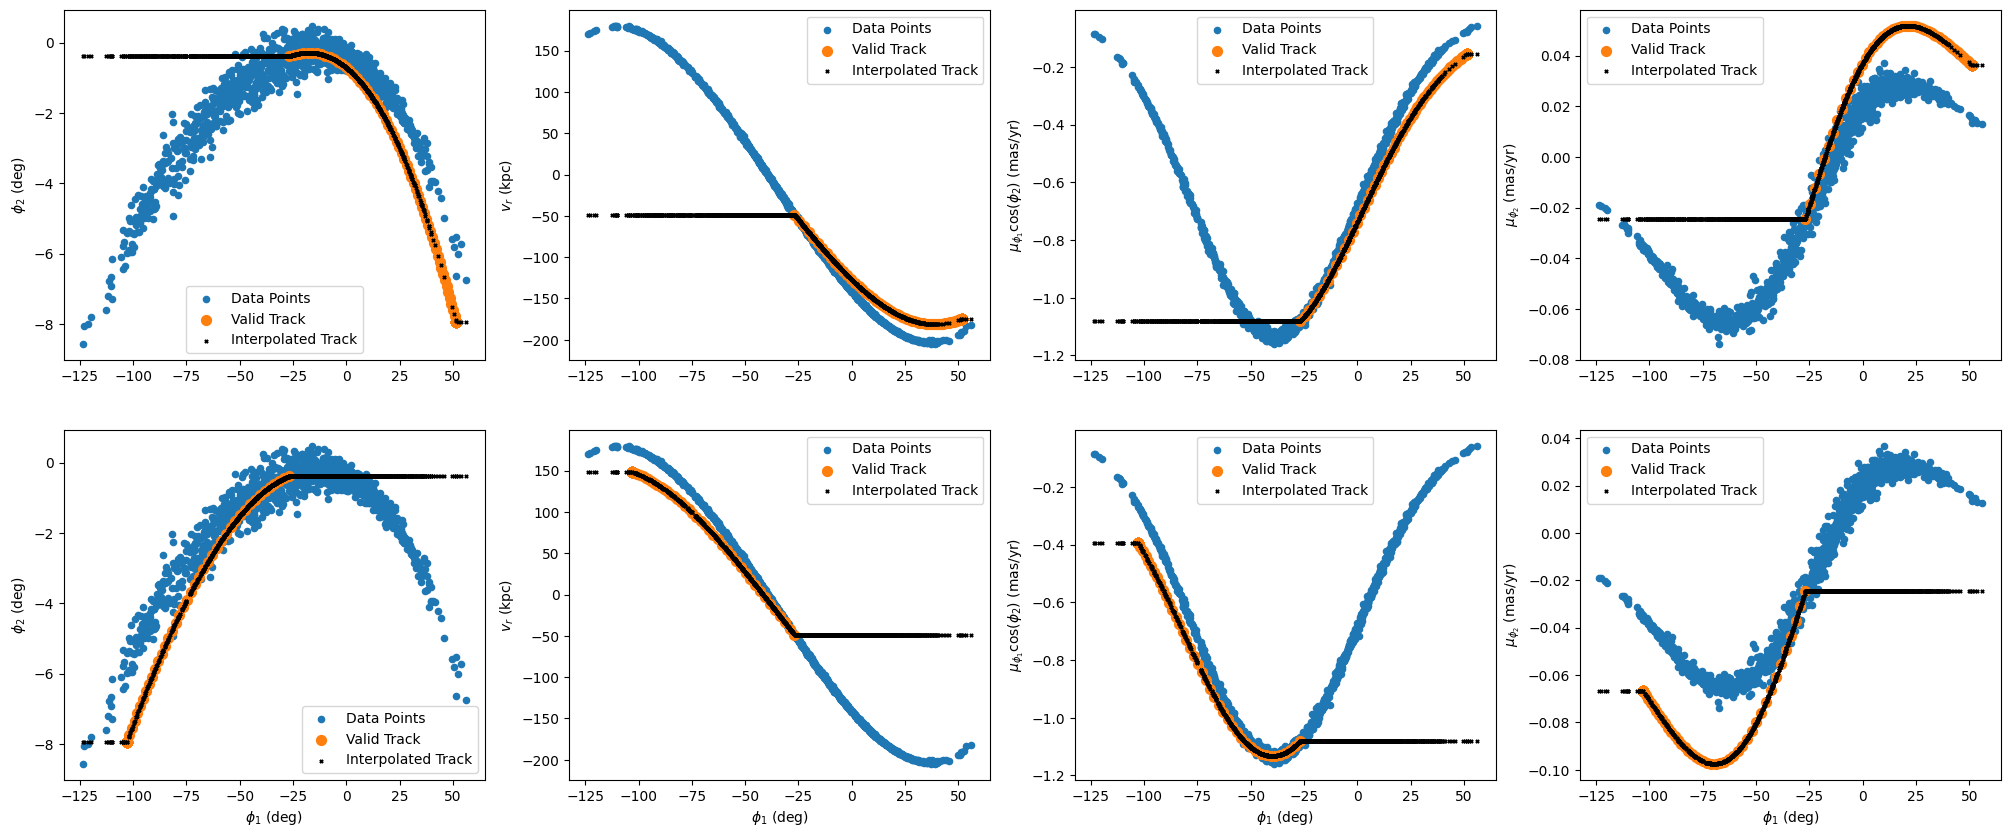

In [4]:
mask_backward = output['mask_backward']
mask_forward = output['mask_forward']
phi1_backward_valid = output['phi1_backward_valid']
phi1_forward_valid = output['phi1_forward_valid']
coord_backward_valid = output['coord_backward_valid']
coord_forward_valid = output['coord_forw_valid']
interp_tracks_backward = output['interp_tracks_backward']
interp_track_forward = output['interp_tracks_forward']
stream_data = output['stream_data']
label = ['$\phi_2$ (deg)', '$v_r$ (kpc)', '$\mu_{\phi_1} \cos(\phi_2)$ (mas/yr)', '$\mu_{\phi_2}$ (mas/yr)']

fig = plt.figure(figsize=(25,10))
k = 1
for i in range(2):
    for j in range(4):
        ax = fig.add_subplot(2, 4, k)
        if k<=4:
            ax.scatter(stream_data[:, 1], stream_data[:, j+2], s=20, label='Data Points')
            ax.scatter(phi1_backward_valid[0], coord_backward_valid[j], s=50, label='Valid Track')
            ax.scatter(stream_data[:, 1], interp_tracks_backward[j], s=5, color='black', marker='x', label='Interpolated Track')
            ax.set_ylabel(label[j])
        else:
            ax.scatter(stream_data[:, 1], stream_data[:, j+2], s=20, label='Data Points')
            ax.scatter(phi1_forward_valid[0], coord_forward_valid[j], s=50, label='Valid Track')
            ax.scatter(stream_data[:, 1], interp_track_forward[j], s=5, color='black', marker='x', label='Interpolated Track')
            ax.set_ylabel(label[j])
            ax.set_xlabel('$\phi_1$ (deg)')
        ax.legend()
        k += 1


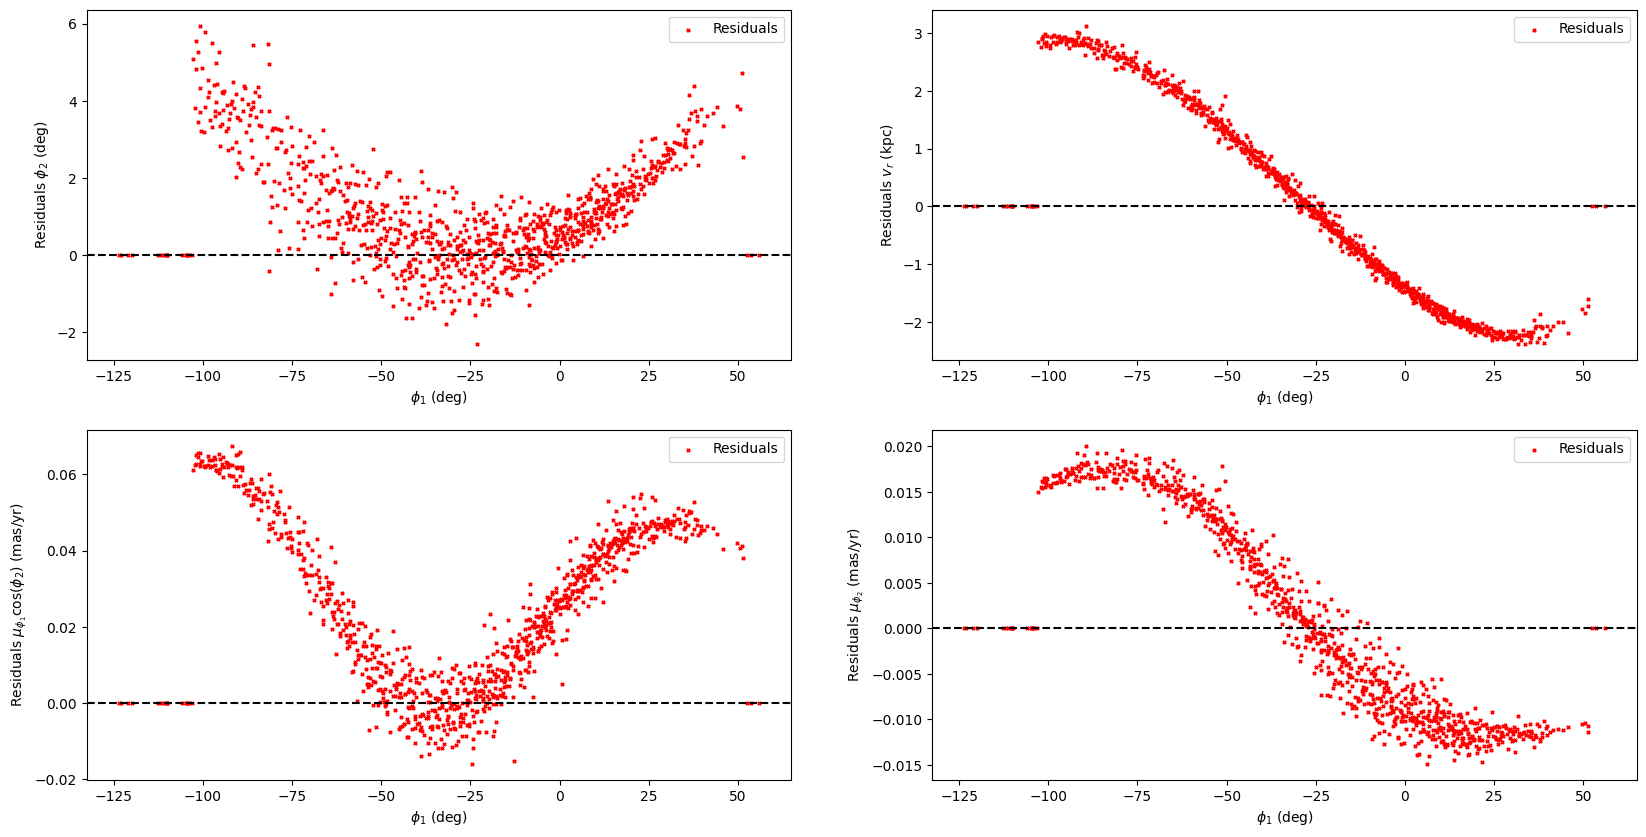

In [5]:
residuals = output['residuals']
# data_coords = output['data_coords']
fig = plt.figure(figsize=(20,10))
k = 1
for i in range(4):
    ax = fig.add_subplot(2, 2, k)
    ax.scatter(stream_data[:, 1], residuals[i], s=5, color='red', marker='x', label='Residuals')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_ylabel('Residuals ' + label[i])
    ax.set_xlabel('$\phi_1$ (deg)')
    ax.legend()
    k += 1

In [ ]:
n_samples = 100
y0_batched = sample_initial_conditions(key, n_samples, params, code_units)

# Shape will be (4, 4)
def minimization_vmap(y0):
    return least_squares(
        fn=run_simulation,
        solver=optimistix.LevenbergMarquardt(rtol=1e-10, atol=1e-10),
        y0=y0,
    ).value

values = jax.vmap(minimization_vmap)(y0_batched)

likelihood = jax.vmap(lambda v: run_simulation(v, return_residual=False))(values)
MLE_index = jnp.argmin(likelihood)


#remember to put FORWARD MODE for the adjoint method when calculating the hessian
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,)
# hessians = jax.vmap(lambda v: jax.jacfwd(jax.jacfwd(run_simulation))(v, False))(values)
hessians = jax.jacfwd(jax.jacfwd(run_simulation))(values[MLE_index], False)

#The Fisher information matrix is the negative of the Hessian of the log-likelihood
fisher_info = hessians

#The covariance matrix is the inverse of the Fisher information matrix
covariance = 2*jnp.linalg.inv(fisher_info)


from chainconsumer import Chain, ChainConsumer, Truth, PlotConfig

colors = ['red', 'blue', 'green', 'purple']
c = ChainConsumer()
chain = Chain.from_covariance(mean=values[MLE_index], 
                                covariance=covariance, 
                                columns=["$M_{vir}^{NFW} [M_\odot]$", "$M^{MN} [M_\odot]$", "$r_s^{NFW} [kpc]$", "$a^{MN} [kpc]$", "$b^{MN} [kpc]$"], 
                                color="emerald",  
                                name=f'Fisher contours',
                                show_contour_labels=True,
                                shade_alpha=0.7
)

c.add_chain(chain)
c.add_marker(location = {"$M_{vir}^{NFW} [M_\odot]$": np.array(values[MLE_index][0]), "$M^{MN} [M_\odot]$": np.array(values[MLE_index][1]),
                            "$r_s^{NFW} [kpc]$": np.array(values[MLE_index][2]), "$a^{MN} [kpc]$": np.array(values[MLE_index][3]), "$b^{MN} [kpc]$": np.array(values[MLE_index][4]),
                            }, color="black", name='MLE', marker_style='P', marker_size=50)

c.add_truth(Truth(location = {"$M_{vir}^{NFW} [M_\odot]$": jnp.log10(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)), 
                            "$M^{MN} [M_\odot]$": jnp.log10(params.MN_params.M * code_units.code_mass.to(u.Msun)),
                            "$r_s^{NFW} [kpc]$": jnp.log10(params.NFW_params.r_s * code_units.code_length.to(u.kpc)),
                            "$a^{MN} [kpc]$": jnp.log10(params.MN_params.a * code_units.code_length.to(u.kpc)),
                            "$b^{MN} [kpc]$": jnp.log10(params.MN_params.b * code_units.code_length.to(u.kpc)),
                            }, 
                            color='black', name="True value"))


c.set_plot_config(
PlotConfig(
    max_ticks=4,
    label_font_size=20,
    tick_font_size=15,
    summary_font_size=20,

))
fig = c.plotter.plot()
# fig.savefig("Fisher_contour_least_square_AllParameters_final.png", 
#             dpi=300,
#             layout='tight')


# Likelihood 

In [29]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1,) #unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
stream_data = projection_on_GD1(final_state, code_units=code_units,)
print("Simulated GD1")


# LET'S TRY OPTIMIZING IT
from odisseo.option_classes import RECURSIVECHECKPOINTADJOING

params_sim = params
config_com = config_com._replace(diffrax_adjoint_method=RECURSIVECHECKPOINTADJOING
)



# stream_data = stream_data[(stream_data[:, 1] > -90) & (stream_data[:, 1] < 10)]  # Filter data within phi1 range
@partial(jit, static_argnames=['return_residual'])
def run_simulation(y, return_residual=True):

    Mvir = y
    # Mvir, M_MN, r_s, a, b, = y
    # Mvir = 10**Mvir
    # M_MN = 10**M_MN
    # r_s = 10**r_s
    # a = 10**a
    # b = 10**b
    r_s = params.NFW_params.r_s * code_units.code_length.to(u.kpc)
    M_MN = params.MN_params.M * code_units.code_mass.to(u.Msun)
    a = params.MN_params.a * code_units.code_length.to(u.kpc)
    b = params.MN_params.b * code_units.code_length.to(u.kpc)

    phi1_min, phi1_max = -150, 60
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir= Mvir * u.Msun.to(code_units.code_mass), 
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a=a * u.kpc.to(code_units.code_length),
                        b=b * u.kpc.to(code_units.code_length),
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.5 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]



    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)

    mask_backward = mask_window_backward & mask_diff_backward
    mask_forward = mask_window_forward & mask_diff_forward



    def coord_backward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.max(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmax(filled)], arr_coord_masked)
        return filled, filled_coord

    def coord_forward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.min(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmin(filled)], arr_coord_masked)
        return filled, filled_coord

    phi1_backward_valid, coord_backward_valid = jax.vmap(lambda coordinate: coord_backward_fill(stream_coordinate_com_backward[:, 0, 1], stream_coordinate_com_backward[:, 0, coordinate], mask_backward))(coordinate=coord_indices)
    phi1_forward_valid, coord_forw_valid = jax.vmap(lambda coordinate: coord_forward_fill(stream_coordinate_com_forward[:, 0, 1], stream_coordinate_com_forward[:, 0, coordinate], mask_forward))(coordinate=coord_indices)


    def interpolate_coord_backward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_backward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_backward_valid[0], coord)
    
    def interpolate_coord_forward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_forward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_forward_valid[0][::-1], coord[::-1])
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_backward_valid)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_forw_valid)  # Shape: (n_coords, n_data)

    

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.1, 5., 0.02, 0.0002, ])
    # sigma = jnp.array([0.15, 5., 0.1, 0.0001]) #from albatross

    mask_correct_interpolation_backward = stream_data[:, 1] <= 60
    mask_correct_interpolation_forward = stream_data[:, 1] >= - 150

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                   0.)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                  0.)
    residuals = jnp.where(mask_stream_backward,
                         residuals_backward,
                         residuals_forward)
    # residuals = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward,
    #                       (data_coords - interp_tracks_backward)/sigma[:, None],
    #                         (data_coords - interp_tracks_forward)/sigma[:, None],)
    # phi1_for_residuals = jnp.where(mask_stream_backward,
    

    # Masks for valid residuals
    mask_backward_full = mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward
    mask_forward_full = mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward
    
    n_eff_backward = jnp.nansum(mask_backward_full) * 4
    n_eff_forward = jnp.nansum(mask_forward_full) * 4
    n_total = n_eff_backward + n_eff_forward
    
    # Chi-squared
    # chi2 = jnp.sum(residuals_backward**2) + jnp.sum(residuals_forward**2)
    chi2 = jnp.sum(residuals**2)
    
    
    if return_residual:
        # Return residuals divided by sqrt(dof) for proper scaling
        # all_residuals = jnp.concatenate([residuals_backward, residuals_forward], axis=1).flatten()
        # return all_residuals 
        return residuals
    else:
        return chi2 

print("beginning least square optimization")


# Example usage:
key = random.PRNGKey(2)
n_samples = 500
# initial_condition = sample_initial_conditions(key, n_samples, params, code_units)
initial_condition = jnp.linspace(params.NFW_params.Mvir*code_units.code_mass.to(u.Msun)*0.5, params.NFW_params.Mvir*code_units.code_mass.to(u.Msun)*2.0, n_samples)
# initial_condition = jnp.log10(jnp.sort(jnp.concatenate([initial_condition, params.NFW_params.Mvir * code_units.code_mass.to(u.Msun) * jnp.ones((1,)) ])))
initial_condition = jnp.sort(jnp.concatenate([initial_condition, params.NFW_params.Mvir * code_units.code_mass.to(u.Msun) * jnp.ones((1,)) ]))
output, grad = jax.vmap(lambda x: jax.value_and_grad(run_simulation)(x, return_residual=False), in_axes=(0,))(initial_condition)
# initial_condition = jnp.log10(jnp.array([4.3683325e11,6.8193902782346756e10 , 16.0, 3.0, 0.28]))
# output = run_simulation(initial_condition, return_residual=False)

Simulated GD1
beginning least square optimization


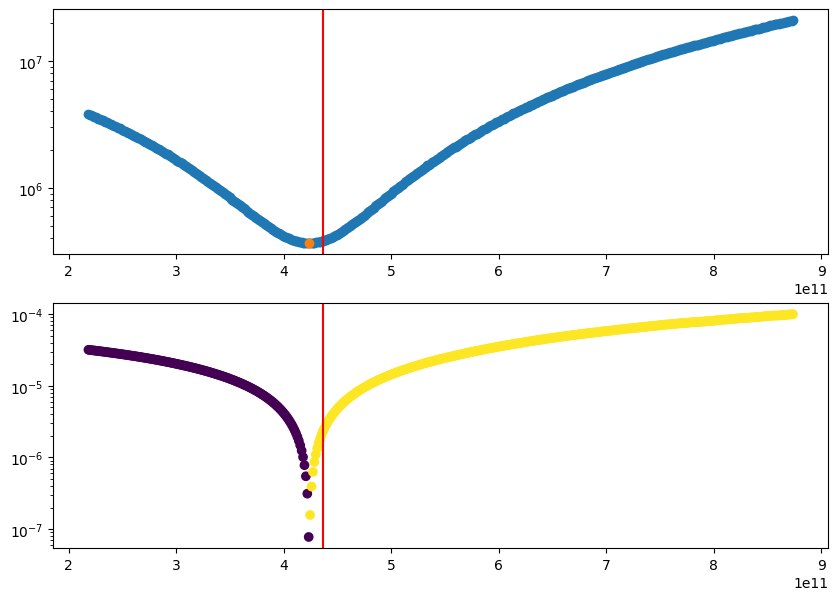

In [31]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(2, 1,1)
ax.scatter(initial_condition, output)
ax.scatter(initial_condition[jnp.argmin(output)], jnp.min(output), label='Chi-squared')
ax.axvline(params.NFW_params.Mvir*code_units.code_mass.to(u.Msun), color='red')
ax.set_yscale('log')

ax = fig.add_subplot(2, 1,2)
ax.scatter(initial_condition,  jnp.sqrt(grad**2),  c=grad>0 )
ax.axvline(params.NFW_params.Mvir*code_units.code_mass.to(u.Msun), color='red')
ax.set_yscale('log')

In [39]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1,) #unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
stream_data = projection_on_GD1(final_state, code_units=code_units,)
print("Simulated GD1")


# LET'S TRY OPTIMIZING IT
from odisseo.option_classes import RECURSIVECHECKPOINTADJOING

params_sim = params
config_com = config_com._replace(diffrax_adjoint_method=RECURSIVECHECKPOINTADJOING
)



# stream_data = stream_data[(stream_data[:, 1] > -90) & (stream_data[:, 1] < 10)]  # Filter data within phi1 range
@partial(jit, static_argnames=['return_residual'])
def run_simulation(y, return_residual=True):

    r_s = y
    # Mvir, M_MN, r_s, a, b, = y
    # Mvir = 10**Mvir
    # M_MN = 10**M_MN
    # r_s = 10**r_s
    # a = 10**a
    # b = 10**b
    Mvir = params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)
    # r_s = params.NFW_params.r_s * code_units.code_length.to(u.kpc)
    M_MN = params.MN_params.M * code_units.code_mass.to(u.Msun)
    a = params.MN_params.a * code_units.code_length.to(u.kpc)
    b = params.MN_params.b * code_units.code_length.to(u.kpc)

    phi1_min, phi1_max = -150, 60
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir= Mvir * u.Msun.to(code_units.code_mass), 
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a=a * u.kpc.to(code_units.code_length),
                        b=b * u.kpc.to(code_units.code_length),
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        print(stream_coordinate.shape)
        return stream_coordinate

    t_end_mag = 0.5 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]



    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)

    mask_backward = mask_window_backward & mask_diff_backward
    mask_forward = mask_window_forward & mask_diff_forward



    def coord_backward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.max(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmax(filled)], arr_coord_masked)
        return filled, filled_coord

    def coord_forward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.min(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmin(filled)], arr_coord_masked)
        return filled, filled_coord

    phi1_backward_valid, coord_backward_valid = jax.vmap(lambda coordinate: coord_backward_fill(stream_coordinate_com_backward[:, 0, 1], stream_coordinate_com_backward[:, 0, coordinate], mask_backward))(coordinate=coord_indices)
    phi1_forward_valid, coord_forw_valid = jax.vmap(lambda coordinate: coord_forward_fill(stream_coordinate_com_forward[:, 0, 1], stream_coordinate_com_forward[:, 0, coordinate], mask_forward))(coordinate=coord_indices)


    def interpolate_coord_backward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_backward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_backward_valid[0], coord)
    
    def interpolate_coord_forward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_forward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_forward_valid[0][::-1], coord[::-1])
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_backward_valid)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_forw_valid)  # Shape: (n_coords, n_data)

    

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.1, 5., 0.02, 0.0002, ])
    # sigma = jnp.array([0.15, 5., 0.1, 0.0001]) #from albatross

    mask_correct_interpolation_backward = stream_data[:, 1] <= 60
    mask_correct_interpolation_forward = stream_data[:, 1] >= - 150

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                   0.)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                  0.)
    residuals = jnp.where(mask_stream_backward,
                         residuals_backward,
                         residuals_forward)
    # residuals = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward,
    #                       (data_coords - interp_tracks_backward)/sigma[:, None],
    #                         (data_coords - interp_tracks_forward)/sigma[:, None],)
    # phi1_for_residuals = jnp.where(mask_stream_backward,
    

    # Masks for valid residuals
    mask_backward_full = mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward
    mask_forward_full = mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward
    
    n_eff_backward = jnp.nansum(mask_backward_full) * 4
    n_eff_forward = jnp.nansum(mask_forward_full) * 4
    n_total = n_eff_backward + n_eff_forward
    
    # Chi-squared
    # chi2 = jnp.sum(residuals_backward**2) + jnp.sum(residuals_forward**2)
    chi2 = jnp.sum(residuals**2)
    
    
    if return_residual:
        # Return residuals divided by sqrt(dof) for proper scaling
        # all_residuals = jnp.concatenate([residuals_backward, residuals_forward], axis=1).flatten()
        # return all_residuals 
        return residuals
    else:
        return chi2 

print("beginning least square optimization")


# Example usage:
key = random.PRNGKey(2)
n_samples = 500
# initial_condition = sample_initial_conditions(key, n_samples, params, code_units)
initial_condition = jnp.linspace(params.NFW_params.r_s*code_units.code_length.to(u.kpc)*0.5, params.NFW_params.r_s*code_units.code_length.to(u.kpc)*2.0, n_samples)

# initial_condition = jnp.log10(jnp.sort(jnp.concatenate([initial_condition, params.NFW_params.Mvir * code_units.code_mass.to(u.Msun) * jnp.ones((1,)) ])))
initial_condition = jnp.sort(jnp.concatenate([initial_condition, params.NFW_params.r_s * code_units.code_length.to(u.kpc) * jnp.ones((1,)) ]))
output, grad = jax.vmap(lambda x: jax.value_and_grad(run_simulation)(x, return_residual=False), in_axes=(0,))(initial_condition)
# initial_condition = jnp.log10(jnp.array([4.3683325e11,6.8193902782346756e10 , 16.0, 3.0, 0.28]))
# output = run_simulation(initial_condition, return_residual=False)

Simulated GD1
beginning least square optimization
(1000, 1, 6)


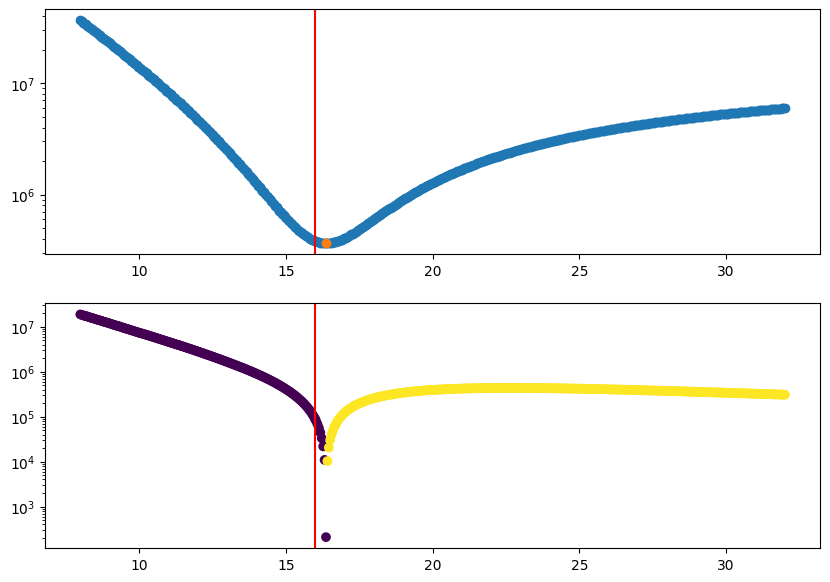

In [33]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(2, 1,1)
ax.scatter(initial_condition, output)
ax.scatter(initial_condition[jnp.argmin(output)], jnp.min(output), label='Chi-squared')
ax.axvline(params.NFW_params.r_s*code_units.code_length.to(u.kpc), color='red')
ax.set_yscale('log')

ax = fig.add_subplot(2, 1,2)
ax.scatter(initial_condition,  jnp.sqrt(grad**2),  c=grad>0 )
ax.axvline(params.NFW_params.r_s*code_units.code_length.to(u.kpc), color='red')
ax.set_yscale('log')

In [6]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1,) #unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
stream_data = projection_on_GD1(final_state, code_units=code_units,)
print("Simulated GD1")


# LET'S TRY OPTIMIZING IT
from odisseo.option_classes import RECURSIVECHECKPOINTADJOING

params_sim = params
config_com = config_com._replace(diffrax_adjoint_method=RECURSIVECHECKPOINTADJOING
)



stream_data = stream_data[(stream_data[:, 1] > -90) & (stream_data[:, 1] < 10)]  # Filter data within phi1 range
@partial(jit, static_argnames=['return_residual'])
def run_simulation(y, return_residual=True):

    Mvir, r_s = y
    # Mvir, M_MN, r_s, a, b, = y
    # Mvir = 10**Mvir
    # M_MN = 10**M_MN
    # r_s = 10**r_s
    # a = 10**a
    # b = 10**b
    # Mvir = params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)
    # r_s = params.NFW_params.r_s * code_units.code_length.to(u.kpc)
    M_MN = params.MN_params.M * code_units.code_mass.to(u.Msun)
    a = params.MN_params.a * code_units.code_length.to(u.kpc)
    b = params.MN_params.b * code_units.code_length.to(u.kpc)

    phi1_min, phi1_max = -150, 60
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir= Mvir * u.Msun.to(code_units.code_mass), 
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a=a * u.kpc.to(code_units.code_length),
                        b=b * u.kpc.to(code_units.code_length),
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.5 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]



    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)

    mask_backward = mask_window_backward & mask_diff_backward
    mask_forward = mask_window_forward & mask_diff_forward



    def coord_backward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.max(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmax(filled)], arr_coord_masked)
        return filled, filled_coord

    def coord_forward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.min(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmin(filled)], arr_coord_masked)
        return filled, filled_coord

    phi1_backward_valid, coord_backward_valid = jax.vmap(lambda coordinate: coord_backward_fill(stream_coordinate_com_backward[:, 0, 1], stream_coordinate_com_backward[:, 0, coordinate], mask_backward))(coordinate=coord_indices)
    phi1_forward_valid, coord_forw_valid = jax.vmap(lambda coordinate: coord_forward_fill(stream_coordinate_com_forward[:, 0, 1], stream_coordinate_com_forward[:, 0, coordinate], mask_forward))(coordinate=coord_indices)


    def interpolate_coord_backward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_backward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_backward_valid[0], coord)
    
    def interpolate_coord_forward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_forward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_forward_valid[0][::-1], coord[::-1])
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_backward_valid)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_forw_valid)  # Shape: (n_coords, n_data)

    

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.1, 5., 0.02, 0.0002, ])
    # sigma = jnp.array([0.15, 5., 0.1, 0.0001]) #from albatross

    mask_correct_interpolation_backward = stream_data[:, 1] <= 60
    mask_correct_interpolation_forward = stream_data[:, 1] >= - 150

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                   0.)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                  0.)
    residuals = jnp.where(mask_stream_backward,
                         residuals_backward,
                         residuals_forward)
    # residuals = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward,
    #                       (data_coords - interp_tracks_backward)/sigma[:, None],
    #                         (data_coords - interp_tracks_forward)/sigma[:, None],)
    # phi1_for_residuals = jnp.where(mask_stream_backward,
    

    # Masks for valid residuals
    mask_backward_full = mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward
    mask_forward_full = mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward
    
    n_eff_backward = jnp.nansum(mask_backward_full) * 4
    n_eff_forward = jnp.nansum(mask_forward_full) * 4
    n_total = n_eff_backward + n_eff_forward
    
    # Chi-squared
    # chi2 = jnp.sum(residuals_backward**2) + jnp.sum(residuals_forward**2)
    chi2 = jnp.sum(residuals**2)
    
    
    if return_residual:
        # Return residuals divided by sqrt(dof) for proper scaling
        # all_residuals = jnp.concatenate([residuals_backward, residuals_forward], axis=1).flatten()
        # return all_residuals 
        return residuals
    else:
        return chi2 

print("beginning least square optimization")


# Example usage:
key = random.PRNGKey(2)
n_samples = 60
# initial_condition = sample_initial_conditions(key, n_samples, params, code_units)
Mvir = jnp.linspace(params.NFW_params.Mvir*code_units.code_mass.to(u.Msun)*0.5, params.NFW_params.Mvir*code_units.code_mass.to(u.Msun)*2.0, n_samples)
r_s = jnp.linspace(params.NFW_params.r_s*code_units.code_length.to(u.kpc)*0.5, params.NFW_params.r_s*code_units.code_length.to(u.kpc)*2.0, n_samples)
mvir, r_s = jnp.meshgrid(Mvir, r_s)
Mvir = mvir.flatten()
r_s = r_s.flatten()
initial_condition = jnp.stack([Mvir, r_s], axis=1)

# initial_condition = jnp.log10(jnp.sort(jnp.concatenate([initial_condition, params.NFW_params.Mvir * code_units.code_mass.to(u.Msun) * jnp.ones((1,)) ])))
# initial_condition = jnp.sort(jnp.concatenate([initial_condition, params.NFW_params.r_s * code_units.code_length.to(u.kpc) * jnp.ones((1,)) ]))
output, grad = jax.vmap(lambda x: jax.value_and_grad(run_simulation)(x, return_residual=False), in_axes=(0,))(initial_condition)
# initial_condition = jnp.log10(jnp.array([4.3683325e11,6.8193902782346756e10 , 16.0, 3.0, 0.28]))
# output = run_simulation(initial_condition, return_residual=False)

Simulated GD1
beginning least square optimization


2025-11-10 23:31:50.590213: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3023] Can't reduce memory use below 7.50GiB (8050258076 bytes) by rematerialization; only reduced to 22.99GiB (24687181510 bytes), down from 23.42GiB (25147981758 bytes) originally


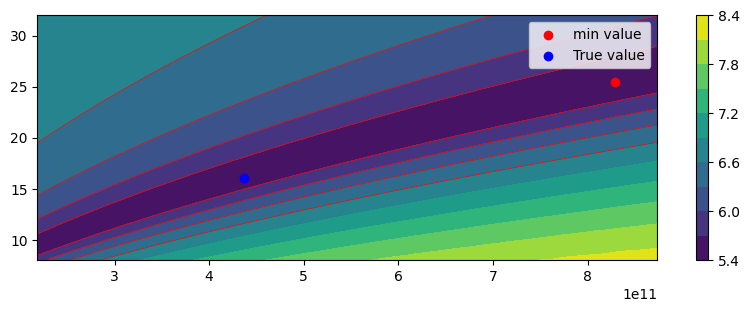

In [7]:
Mvir = jnp.linspace(params.NFW_params.Mvir*code_units.code_mass.to(u.Msun)*0.5, params.NFW_params.Mvir*code_units.code_mass.to(u.Msun)*2.0, n_samples)
r_s = jnp.linspace(params.NFW_params.r_s*code_units.code_length.to(u.kpc)*0.5, params.NFW_params.r_s*code_units.code_length.to(u.kpc)*2.0, n_samples)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(2, 1,1)
c = ax.contourf(Mvir, r_s, jnp.log10(output.reshape((n_samples, n_samples))), levels=10)
fig.colorbar(c, ax=ax)
ax.contour(c, levels=c.levels[:5], colors='red', linewidths=0.5)
ax.scatter(initial_condition[jnp.argmin(output), 0], initial_condition[jnp.argmin(output), 1], label='min value', color='red')
ax.scatter(params.NFW_params.Mvir*code_units.code_mass.to(u.Msun), params.NFW_params.r_s*code_units.code_length.to(u.kpc), label='True value', color='blue')
ax.legend()

# ax.scatter(initial_condition[jnp.argmin(output), 1], initial_condition[jnp.argmin(output), 0], label='Chi-squared', color='red')
# ax.axhline(params.NFW_params.Mvir*code_units.code_mass.to(u.Msun), color='red')
# ax.axvline(params.NFW_params.r_s*code_units.code_length.to(u.kpc), color='red')


# Using also ICRS like in IBATA Fermionic 

In [13]:


@jax.jit
def halo_to_sun(Xhalo: jnp.ndarray) -> jnp.ndarray:
    """
    Conversion from simulation frame to cartesian frame centred at Sun
    Args:
      Xhalo: 3d position (x [kpc], y [kpc], z [kpc]) in simulation frame
    Returns:
      3d position (x_s [kpc], y_s [kpc], z_s [kpc]) in Sun frame
    Examples

    --------
    >>> halo_to_sun(jnp.array([1.0, 2.0, 3.0]))
    """
    sunx = 8.0
    xsun = sunx - Xhalo[0]
    ysun = Xhalo[1]
    zsun = Xhalo[2]
    return jnp.array([xsun, ysun, zsun])


@jax.jit
def sun_to_gal(Xsun: jnp.ndarray) -> jnp.ndarray:
    """
    Conversion from sun cartesian frame to galactic co-ordinates
    Args:
      Xsun: 3d position (x_s [kpc], y_s [kpc], z_s [kpc]) in Sun frame
    Returns:
      3d position (r [kpc], b [rad], l [rad]) in galactic frame
    Examples
    --------
    >>> sun_to_gal(jnp.array([1.0, 2.0, 3.0]))
    """
    r = jnp.linalg.norm(Xsun)
    b = jnp.arcsin(Xsun[2] / r)
    l = jnp.arctan2(Xsun[1], Xsun[0])
    return jnp.array([r, b, l])


@jax.jit
def gal_to_equat(Xgal: jnp.ndarray) -> jnp.ndarray:
    """
    Conversion from galactic co-ordinates to equatorial co-ordinates
    Args:
      Xgal: 3d position (r [kpc], b [rad], l [rad]) in galactic frame
    Returns:
      3d position (r [kpc], alpha [rad], delta [rad]) in equatorial frame
    Examples
    --------
    >>> gal_to_equat(jnp.array([1.0, 2.0, 3.0]))
    """
    dNGPdeg = 27.12825118085622
    lNGPdeg = 122.9319185680026
    aNGPdeg = 192.85948
    dNGP = dNGPdeg * jnp.pi / 180.0
    lNGP = lNGPdeg * jnp.pi / 180.0
    aNGP = aNGPdeg * jnp.pi / 180.0
    r = Xgal[0]
    b = Xgal[1]
    l = Xgal[2]
    sb = jnp.sin(b)
    cb = jnp.cos(b)
    sl = jnp.sin(lNGP - l)
    cl = jnp.cos(lNGP - l)
    cs = cb * sl
    cc = jnp.cos(dNGP) * sb - jnp.sin(dNGP) * cb * cl
    alpha = jnp.arctan(cs / cc) + aNGP
    delta = jnp.arcsin(jnp.sin(dNGP) * sb + jnp.cos(dNGP) * cb * cl)
    return jnp.array([r, alpha, delta])

def transform_velocity(transform_fn, X, V):
    """
    Generic velocity transformation through coordinate mapping.

    Args:
      transform_fn: function R^3 → R^3 mapping positions to new coordinates
      X: position vector in original coordinates (3,)
      V: velocity vector in original coordinates (3,)

    Returns:
      velocity vector in transformed coordinates (3,)
    """
    J = jax.jacobian(transform_fn)(X)  # (3,3) Jacobian
    return J @ V

def halo_to_equatorial(Xhalo):
    Xsun = halo_to_sun(Xhalo)
    Xgal = sun_to_gal(Xsun)
    Xeq  = gal_to_equat(Xgal)
    return Xeq


#vamp functions
halo_to_equatorial_batch = jax.vmap(halo_to_equatorial, in_axes=(0))
transform_velocity_batch = jax.vmap(transform_velocity, in_axes=(None, 0, 0))


    

code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1,) #unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
GD1_coord = projection_on_GD1(final_state, code_units=code_units,)
pos_final = final_state[:, 0] * code_units.code_length.to(u.kpc)
vel_final = final_state[:, 1] * code_units.code_velocity.to(u.kpc / u.Myr)
equat_coords = halo_to_equatorial_batch(pos_final)
equat_vels = transform_velocity_batch(halo_to_equatorial, pos_final, vel_final)
stream_data = jnp.array([GD1_coord[:, 0], #r
                         GD1_coord[:, 1], #phi1
                         GD1_coord[:, 2], #phi2
                         equat_vels[:, 1] * 2.0626480624709636e8 / 1e6 * jnp.cos(equat_coords[:, 2]), #v_alpha
                         equat_vels[:, 2] * 2.0626480624709636e8 / 1e6, #v_delta
                         equat_vels[:, 0] * (u.kpc/u.Myr).to(u.km/u.s), #v_r                          
                         ]).T
print("Simulated GD1")


# LET'S TRY OPTIMIZING IT
from odisseo.option_classes import RECURSIVECHECKPOINTADJOING

params_sim = params
config_com = config_com._replace(diffrax_adjoint_method=RECURSIVECHECKPOINTADJOING
)



stream_data = stream_data[(stream_data[:, 1] > -90) & (stream_data[:, 1] < 10)]  # Filter data within phi1 range
@partial(jit, static_argnames=['return_residual'])
def run_simulation(y, return_residual=True):

    Mvir, r_s = y
    # Mvir, M_MN, r_s, a, b, = y
    # Mvir = 10**Mvir
    # M_MN = 10**M_MN
    # r_s = 10**r_s
    # a = 10**a
    # b = 10**b
    # Mvir = params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)
    # r_s = params.NFW_params.r_s * code_units.code_length.to(u.kpc)
    M_MN = params.MN_params.M * code_units.code_mass.to(u.Msun)
    a = params.MN_params.a * code_units.code_length.to(u.kpc)
    b = params.MN_params.b * code_units.code_length.to(u.kpc)

    phi1_min, phi1_max = -150, 60
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir= Mvir * u.Msun.to(code_units.code_mass), 
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a=a * u.kpc.to(code_units.code_length),
                        b=b * u.kpc.to(code_units.code_length),
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate_GD1 = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        pos_stream = snapshots.states[:, 0, 0] * code_units.code_length.to(u.kpc)
        vel_stream = snapshots.states[:, 0, 1] * code_units.code_velocity.to(u.kpc / u.Myr)
        equat_coords_stream = halo_to_equatorial_batch(pos_stream)
        equat_vels_stream = transform_velocity_batch(halo_to_equatorial, pos_stream, vel_stream)
        stream_coordinate = jnp.concatenate([stream_coordinate_GD1[:, :, 0].reshape(1000, 1, 1), #r
                                            stream_coordinate_GD1[:, :, 1].reshape(1000, 1, 1), #phi1
                                            stream_coordinate_GD1[:, :, 2].reshape(1000, 1, 1), #phi2
                                            equat_vels_stream[:, 1].reshape(1000, 1, 1) * 2.0626480624709636e8 / 1e6 * jnp.cos(equat_coords_stream[:, 2].reshape(1000, 1, 1)), #v_alpha
                                            equat_vels_stream[:, 2].reshape(1000, 1, 1) * 2.0626480624709636e8 / 1e6, #v_delta
                                            equat_vels_stream[:, 0].reshape(1000, 1, 1) * (u.kpc/u.Myr).to(u.km/u.s), #v_r                          
                                     ], axis=2)
        return stream_coordinate

    t_end_mag = 0.2 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]



    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)

    mask_backward = mask_window_backward & mask_diff_backward
    mask_forward = mask_window_forward & mask_diff_forward



    def coord_backward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.max(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmax(filled)], arr_coord_masked)
        return filled, filled_coord

    def coord_forward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.min(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmin(filled)], arr_coord_masked)
        return filled, filled_coord

    phi1_backward_valid, coord_backward_valid = jax.vmap(lambda coordinate: coord_backward_fill(stream_coordinate_com_backward[:, 0, 1], stream_coordinate_com_backward[:, 0, coordinate], mask_backward))(coordinate=coord_indices)
    phi1_forward_valid, coord_forw_valid = jax.vmap(lambda coordinate: coord_forward_fill(stream_coordinate_com_forward[:, 0, 1], stream_coordinate_com_forward[:, 0, coordinate], mask_forward))(coordinate=coord_indices)


    def interpolate_coord_backward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_backward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_backward_valid[0], coord)
    
    def interpolate_coord_forward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_forward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_forward_valid[0][::-1], coord[::-1])
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_backward_valid)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_forw_valid)  # Shape: (n_coords, n_data)

    

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 2, 2, 10 ])
    # sigma = jnp.array([0.15, 5., 0.1, 0.0001]) #from albatross

    mask_correct_interpolation_backward = stream_data[:, 1] <= 60
    mask_correct_interpolation_forward = stream_data[:, 1] >= - 150

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                   0.)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                  0.)
    residuals = jnp.where(mask_stream_backward,
                         residuals_backward,
                         residuals_forward)
    # residuals = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward,
    #                       (data_coords - interp_tracks_backward)/sigma[:, None],
    #                         (data_coords - interp_tracks_forward)/sigma[:, None],)
    # phi1_for_residuals = jnp.where(mask_stream_backward,
    

    # Masks for valid residuals
    mask_backward_full = mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward
    mask_forward_full = mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward
    
    n_eff_backward = jnp.nansum(mask_backward_full) * 4
    n_eff_forward = jnp.nansum(mask_forward_full) * 4
    n_total = n_eff_backward + n_eff_forward
    
    # Chi-squared
    # chi2 = jnp.sum(residuals_backward**2) + jnp.sum(residuals_forward**2)
    chi2 = jnp.sum(residuals**2)
    
    
    if return_residual:
        # Return residuals divided by sqrt(dof) for proper scaling
        # all_residuals = jnp.concatenate([residuals_backward, residuals_forward], axis=1).flatten()
        # return all_residuals 
        return residuals
    else:
        return chi2 

print("beginning least square optimization")


# Example usage:
key = random.PRNGKey(2)
n_samples = 60
# initial_condition = sample_initial_conditions(key, n_samples, params, code_units)
Mvir = jnp.linspace(params.NFW_params.Mvir*code_units.code_mass.to(u.Msun)*0.5, params.NFW_params.Mvir*code_units.code_mass.to(u.Msun)*2.0, n_samples-1)
Mvir = jnp.sort(jnp.concatenate([Mvir, jnp.array([params.NFW_params.Mvir*code_units.code_mass.to(u.Msun)])]))
r_s = jnp.linspace(params.NFW_params.r_s*code_units.code_length.to(u.kpc)*0.5, params.NFW_params.r_s*code_units.code_length.to(u.kpc)*2.0, n_samples-1)
r_s = jnp.sort(jnp.concatenate([r_s, jnp.array([params.NFW_params.r_s*code_units.code_length.to(u.kpc)])]))

mvir, r_s = jnp.meshgrid(Mvir, r_s)
Mvir = mvir.flatten()
r_s = r_s.flatten()
initial_condition = jnp.stack([Mvir, r_s], axis=1)

# initial_condition = jnp.log10(jnp.sort(jnp.concatenate([initial_condition, params.NFW_params.Mvir * code_units.code_mass.to(u.Msun) * jnp.ones((1,)) ])))
# initial_condition = jnp.sort(jnp.concatenate([initial_condition, params.NFW_params.r_s * code_units.code_length.to(u.kpc) * jnp.ones((1,)) ]))
output, grad = jax.vmap(lambda x: jax.value_and_grad(run_simulation)(x, return_residual=False), in_axes=(0,))(initial_condition)
# initial_condition = jnp.log10(jnp.array([4.3683325e11,6.8193902782346756e10 , 16.0, 3.0, 0.28]))
# output = run_simulation(initial_condition, return_residual=False)

Simulated GD1
beginning least square optimization


2025-11-11 10:38:10.539791: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3023] Can't reduce memory use below 3.29GiB (3535788696 bytes) by rematerialization; only reduced to 27.33GiB (29344553138 bytes), down from 27.85GiB (29900054790 bytes) originally


Text(0, 0.5, 'r_s [kpc]')

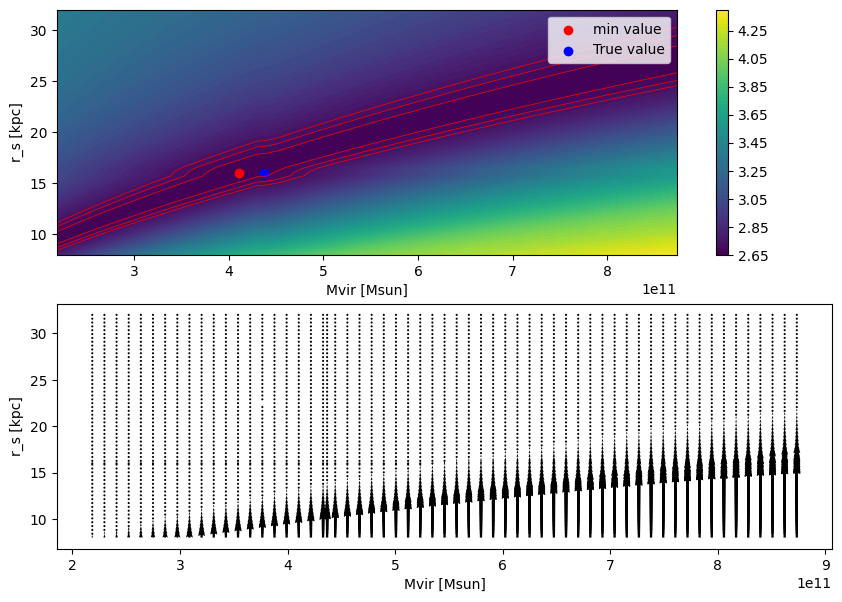

In [17]:
Mvir = jnp.linspace(params.NFW_params.Mvir*code_units.code_mass.to(u.Msun)*0.5, params.NFW_params.Mvir*code_units.code_mass.to(u.Msun)*2.0, n_samples)
r_s = jnp.linspace(params.NFW_params.r_s*code_units.code_length.to(u.kpc)*0.5, params.NFW_params.r_s*code_units.code_length.to(u.kpc)*2.0, n_samples)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(2, 1,1)
c = ax.contourf(Mvir, r_s, jnp.log10(output.reshape((n_samples, n_samples))), levels=70)
fig.colorbar(c, ax=ax)
ax.contour(c, levels=c.levels[:4], colors='red', linewidths=0.5)
ax.scatter(initial_condition[jnp.argmin(output), 0], initial_condition[jnp.argmin(output), 1], label='min value',  color='red')
ax.scatter(params.NFW_params.Mvir*code_units.code_mass.to(u.Msun), params.NFW_params.r_s*code_units.code_length.to(u.kpc), label='True value', color='blue')
ax.set_xlabel('Mvir [Msun]')
ax.set_ylabel('r_s [kpc]')
ax.legend()

ax = fig.add_subplot(2, 1,2)
ax.quiver(initial_condition[:, 0], initial_condition[:, 1], -grad[:, 0], -grad[:, 1], color='black', width=0.003)
ax.set_xlabel('Mvir [Msun]')
ax.set_ylabel('r_s [kpc]')

# ax.scatter(initial_condition[jnp.argmin(output), 1], initial_condition[jnp.argmin(output), 0], label='Chi-squared', color='red')
# ax.axhline(params.NFW_params.Mvir*code_units.code_mass.to(u.Msun), color='red')
# ax.axvline(params.NFW_params.r_s*code_units.code_length.to(u.kpc), color='red')


In [10]:
jnp.min(output), initial_condition[jnp.argmin(output)]

(Array(2351.4954, dtype=float32),
 Array([6.3964873e+11, 2.1714287e+01], dtype=float32))

In [105]:
jnp.array([params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), params.NFW_params.r_s * code_units.code_length.to(u.kpc)])

Array([4.3683326e+11, 1.6000000e+01], dtype=float32)

In [10]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1,) #unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(5*4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
GD1_coord = projection_on_GD1(final_state, code_units=code_units,)
pos_final = final_state[:, 0] * code_units.code_length.to(u.kpc)
vel_final = final_state[:, 1] * code_units.code_velocity.to(u.kpc / u.Myr)
equat_coords = halo_to_equatorial_batch(pos_final)
equat_vels = transform_velocity_batch(halo_to_equatorial, pos_final, vel_final)
stream_data = jnp.array([GD1_coord[:, 0], #r
                         GD1_coord[:, 1], #phi1
                         GD1_coord[:, 2], #phi2
                         equat_vels[:, 1] * 2.0626480624709636e8 / 1e6 * jnp.cos(equat_coords[:, 2]), #v_alpha
                         equat_vels[:, 2] * 2.0626480624709636e8 / 1e6, #v_delta
                         equat_vels[:, 0] * (u.kpc/u.Myr).to(u.km/u.s), #v_r                          
                         ]).T
print("Simulated GD1")


# LET'S TRY OPTIMIZING IT

params_sim = params
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,
)



# stream_data = stream_data[(stream_data[:, 1] > -90) & (stream_data[:, 1] < 10)]  # Filter data within phi1 range
@partial(jit, static_argnames=['return_residual'])
def run_simulation( y, return_residual=True):

    Mvir, M_MN, r_s, a, b, = y
    Mvir = 10**Mvir
    M_MN = 10**M_MN
    r_s = 10**r_s
    a = 10**a
    b = 10**b

    phi1_min, phi1_max = -150, 60
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir=Mvir * u.Msun.to(code_units.code_mass), 
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a=a * u.kpc.to(code_units.code_length),
                        b=b * u.kpc.to(code_units.code_length),
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate_GD1 = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        pos_stream = snapshots.states[:, 0, 0] * code_units.code_length.to(u.kpc)
        vel_stream = snapshots.states[:, 0, 1] * code_units.code_velocity.to(u.kpc / u.Myr)
        equat_coords_stream = halo_to_equatorial_batch(pos_stream)
        equat_vels_stream = transform_velocity_batch(halo_to_equatorial, pos_stream, vel_stream)
        stream_coordinate = jnp.concatenate([stream_coordinate_GD1[:, :, 0].reshape(1000, 1, 1), #r
                                            stream_coordinate_GD1[:, :, 1].reshape(1000, 1, 1), #phi1
                                            stream_coordinate_GD1[:, :, 2].reshape(1000, 1, 1), #phi2
                                            equat_vels_stream[:, 1].reshape(1000, 1, 1) * 2.0626480624709636e8 / 1e6 * jnp.cos(equat_coords_stream[:, 2].reshape(1000, 1, 1)), #v_alpha
                                            equat_vels_stream[:, 2].reshape(1000, 1, 1) * 2.0626480624709636e8 / 1e6, #v_delta
                                            equat_vels_stream[:, 0].reshape(1000, 1, 1) * (u.kpc/u.Myr).to(u.km/u.s), #v_r                          
                                     ], axis=2)
        return stream_coordinate

    t_end_mag = 1 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]



    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)

    mask_backward = mask_window_backward & mask_diff_backward
    mask_forward = mask_window_forward & mask_diff_forward



    def coord_backward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.max(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmax(filled)], arr_coord_masked)
        return filled, filled_coord

    def coord_forward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.min(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmin(filled)], arr_coord_masked)
        return filled, filled_coord

    phi1_backward_valid, coord_backward_valid = jax.vmap(lambda coordinate: coord_backward_fill(stream_coordinate_com_backward[:, 0, 1], stream_coordinate_com_backward[:, 0, coordinate], mask_backward))(coordinate=coord_indices)
    phi1_forward_valid, coord_forw_valid = jax.vmap(lambda coordinate: coord_forward_fill(stream_coordinate_com_forward[:, 0, 1], stream_coordinate_com_forward[:, 0, coordinate], mask_forward))(coordinate=coord_indices)


    def interpolate_coord_backward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_backward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_backward_valid[0], coord)
    
    def interpolate_coord_forward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_forward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_forward_valid[0][::-1], coord[::-1])
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_backward_valid)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_forw_valid)  # Shape: (n_coords, n_data)

    

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])
    # sigma = jnp.array([0.15, 5., 0.1, 0.0001]) #from albatross

    mask_correct_interpolation_backward = stream_data[:, 1] <= 60
    mask_correct_interpolation_forward = stream_data[:, 1] >= - 150

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                   0.)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                  0.)
    residuals = jnp.where(mask_stream_backward,
                         residuals_backward,
                         residuals_forward)
    # residuals = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward,
    #                       (data_coords - interp_tracks_backward)/sigma[:, None],
    #                         (data_coords - interp_tracks_forward)/sigma[:, None],)
    # phi1_for_residuals = jnp.where(mask_stream_backward,
    
    return {'stream_coordinate_com_backward': stream_coordinate_com_backward,
            'stream_coordinate_com_forward': stream_coordinate_com_forward,
            'mask_backward': mask_backward,
            'mask_forward': mask_forward,
            'phi1_backward_valid': phi1_backward_valid,
            'phi1_forward_valid': phi1_forward_valid,
            'coord_backward_valid': coord_backward_valid,
            'coord_forw_valid': coord_forw_valid,
            'interp_tracks_backward': interp_tracks_backward,
            'interp_tracks_forward': interp_tracks_forward,
            'residuals': residuals,
            'stream_data': stream_data,
    }
    # Masks for valid residuals
    mask_backward_full = mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward
    mask_forward_full = mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward
    
    n_eff_backward = jnp.nansum(mask_backward_full) * 4
    n_eff_forward = jnp.nansum(mask_forward_full) * 4
    n_total = n_eff_backward + n_eff_forward
    
    # Chi-squared
    # chi2 = jnp.sum(residuals_backward**2) + jnp.sum(residuals_forward**2)
    chi2 = jnp.sum(residuals**2)
    
    
    if return_residual:
        # Return residuals divided by sqrt(dof) for proper scaling
        # all_residuals = jnp.concatenate([residuals_backward, residuals_forward], axis=1).flatten()
        # return all_residuals 
        return residuals
    else:
        return chi2 

print("beginning least square optimization")

from optimistix import least_squares
import optimistix


# Shape will be (4, 4)
def sample_initial_conditions(key, n_samples, params, code_units):
    """
    Sample initial conditions from a uniform prior.
    
    Parameters are sampled uniformly in log-space between 0.5x and 2x the true values.
    
    Args:
        key: JAX random key
        n_samples: Number of samples to generate
        params: SimulationParams object with true parameter values
        code_units: CodeUnits object for unit conversions
    
    Returns:
        Array of shape (n_samples, 5) with log10 of [Mvir, M_MN, r_s, a, b]
    """
    # Get true values in physical units
    true_Mvir = params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)
    true_M_MN = params.MN_params.M * code_units.code_mass.to(u.Msun)
    true_r_s = params.NFW_params.r_s * code_units.code_length.to(u.kpc)
    true_a = params.MN_params.a * code_units.code_length.to(u.kpc)
    true_b = params.MN_params.b * code_units.code_length.to(u.kpc)
    
    # Define bounds: [0.5 * true_value, 2.0 * true_value]
    min_factor = 0.5
    max_factor = 2.0
    
    # Stack true values
    true_values = jnp.array([true_Mvir, true_M_MN, true_r_s, true_a, true_b])
    
    # Calculate min and max in log space
    log_min = jnp.log10(true_values * min_factor)
    log_max = jnp.log10(true_values * max_factor)
    
    # min_vals = true_values * min_factor
    # max_vals = true_values * max_factor
    # Sample uniformly in log space
    keys = random.split(key, 5)
    samples = []
    
    for i in range(5):
        param_samples = random.uniform(
            keys[i], 
            shape=(n_samples,), 
            minval=log_min[i], 
            maxval=log_max[i]
        )
        samples.append(param_samples)
    
    # Stack into (n_samples, 5) array
    y0_batched = jnp.stack(samples, axis=1)
    
    return y0_batched


# Example usage:
key = random.PRNGKey(2)
n_samples = 1
initial_condition = sample_initial_conditions(key, n_samples, params, code_units)
output = run_simulation(initial_condition[0], return_residual=False)
# initial_condition = jnp.log10(jnp.array([4.3683325e11,6.8193902782346756e10 , 16.0, 3.0, 0.28]))
# output = run_simulation(initial_condition, return_residual=False)

Simulated GD1
beginning least square optimization


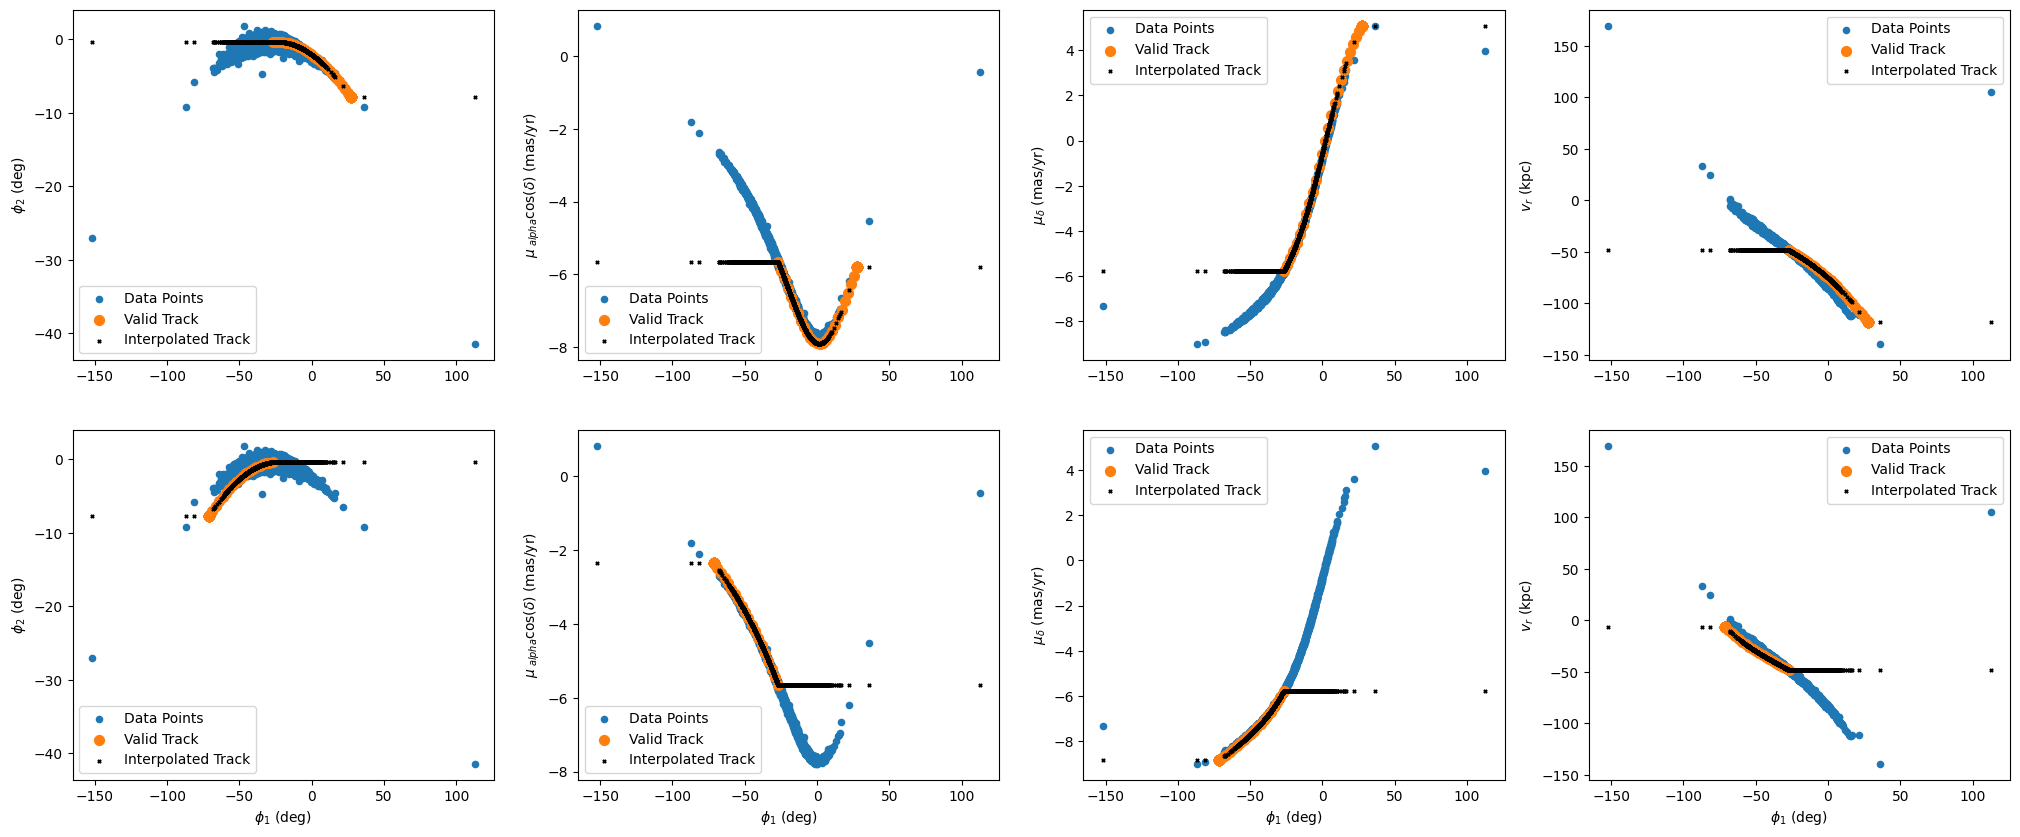

In [11]:
mask_backward = output['mask_backward']
mask_forward = output['mask_forward']
phi1_backward_valid = output['phi1_backward_valid']
phi1_forward_valid = output['phi1_forward_valid']
coord_backward_valid = output['coord_backward_valid']
coord_forward_valid = output['coord_forw_valid']
interp_tracks_backward = output['interp_tracks_backward']
interp_track_forward = output['interp_tracks_forward']
stream_data = output['stream_data']
label = ['$\phi_2$ (deg)', '$\mu_{\ alpha} \cos(\delta)$ (mas/yr)', '$\mu_{\delta}$ (mas/yr)', '$v_r$ (kpc)',]

fig = plt.figure(figsize=(25,10))
k = 1
for i in range(2):
    for j in range(4):
        ax = fig.add_subplot(2, 4, k)
        if k<=4:
            ax.scatter(stream_data[:, 1], stream_data[:, j+2], s=20, label='Data Points')
            ax.scatter(phi1_backward_valid[0], coord_backward_valid[j], s=50, label='Valid Track')
            ax.scatter(stream_data[:, 1], interp_tracks_backward[j], s=5, color='black', marker='x', label='Interpolated Track')
            ax.set_ylabel(label[j])
        else:
            ax.scatter(stream_data[:, 1], stream_data[:, j+2], s=20, label='Data Points')
            ax.scatter(phi1_forward_valid[0], coord_forward_valid[j], s=50, label='Valid Track')
            ax.scatter(stream_data[:, 1], interp_track_forward[j], s=5, color='black', marker='x', label='Interpolated Track')
            ax.set_ylabel(label[j])
            ax.set_xlabel('$\phi_1$ (deg)')
        ax.legend()
        k += 1


Simulated GD1
beginning least square optimization


/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


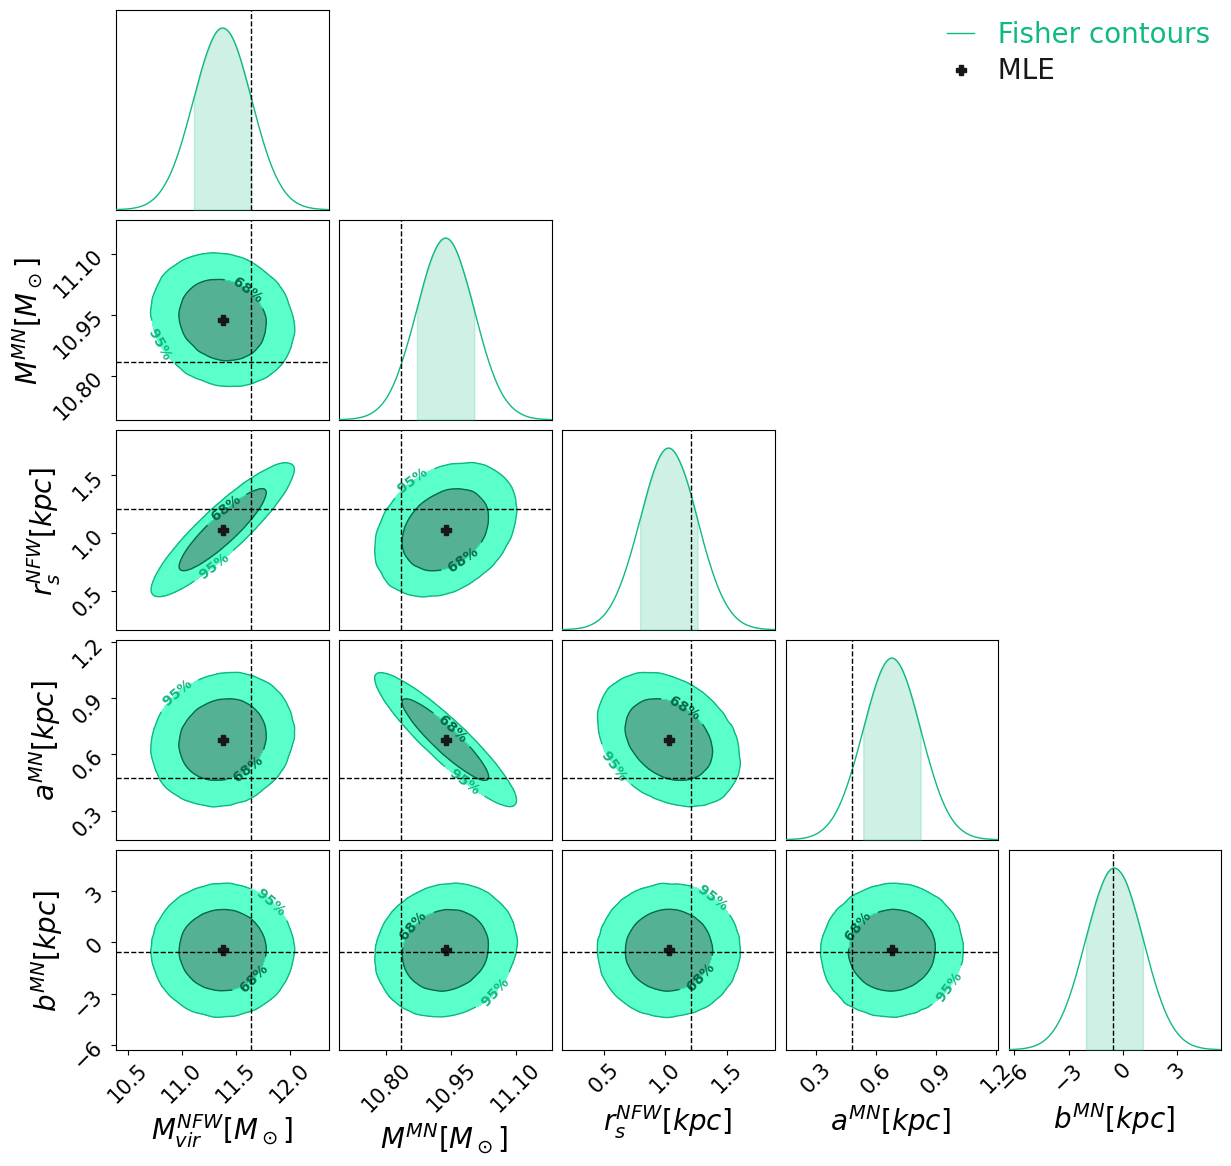

In [ ]:
@jax.jit
def halo_to_sun(Xhalo: jnp.ndarray) -> jnp.ndarray:
    """
    Conversion from simulation frame to cartesian frame centred at Sun
    Args:
      Xhalo: 3d position (x [kpc], y [kpc], z [kpc]) in simulation frame
    Returns:
      3d position (x_s [kpc], y_s [kpc], z_s [kpc]) in Sun frame
    Examples

    --------
    >>> halo_to_sun(jnp.array([1.0, 2.0, 3.0]))
    """
    sunx = 8.0
    xsun = sunx - Xhalo[0]
    ysun = Xhalo[1]
    zsun = Xhalo[2]
    return jnp.array([xsun, ysun, zsun])


@jax.jit
def sun_to_gal(Xsun: jnp.ndarray) -> jnp.ndarray:
    """
    Conversion from sun cartesian frame to galactic co-ordinates
    Args:
      Xsun: 3d position (x_s [kpc], y_s [kpc], z_s [kpc]) in Sun frame
    Returns:
      3d position (r [kpc], b [rad], l [rad]) in galactic frame
    Examples
    --------
    >>> sun_to_gal(jnp.array([1.0, 2.0, 3.0]))
    """
    r = jnp.linalg.norm(Xsun)
    b = jnp.arcsin(Xsun[2] / r)
    l = jnp.arctan2(Xsun[1], Xsun[0])
    return jnp.array([r, b, l])


@jax.jit
def gal_to_equat(Xgal: jnp.ndarray) -> jnp.ndarray:
    """
    Conversion from galactic co-ordinates to equatorial co-ordinates
    Args:
      Xgal: 3d position (r [kpc], b [rad], l [rad]) in galactic frame
    Returns:
      3d position (r [kpc], alpha [rad], delta [rad]) in equatorial frame
    Examples
    --------
    >>> gal_to_equat(jnp.array([1.0, 2.0, 3.0]))
    """
    dNGPdeg = 27.12825118085622
    lNGPdeg = 122.9319185680026
    aNGPdeg = 192.85948
    dNGP = dNGPdeg * jnp.pi / 180.0
    lNGP = lNGPdeg * jnp.pi / 180.0
    aNGP = aNGPdeg * jnp.pi / 180.0
    r = Xgal[0]
    b = Xgal[1]
    l = Xgal[2]
    sb = jnp.sin(b)
    cb = jnp.cos(b)
    sl = jnp.sin(lNGP - l)
    cl = jnp.cos(lNGP - l)
    cs = cb * sl
    cc = jnp.cos(dNGP) * sb - jnp.sin(dNGP) * cb * cl
    alpha = jnp.arctan(cs / cc) + aNGP
    delta = jnp.arcsin(jnp.sin(dNGP) * sb + jnp.cos(dNGP) * cb * cl)
    return jnp.array([r, alpha, delta])

def transform_velocity(transform_fn, X, V):
    """
    Generic velocity transformation through coordinate mapping.

    Args:
      transform_fn: function R^3 → R^3 mapping positions to new coordinates
      X: position vector in original coordinates (3,)
      V: velocity vector in original coordinates (3,)

    Returns:
      velocity vector in transformed coordinates (3,)
    """
    J = jax.jacobian(transform_fn)(X)  # (3,3) Jacobian
    return J @ V

def halo_to_equatorial(Xhalo):
    Xsun = halo_to_sun(Xhalo)
    Xgal = sun_to_gal(Xsun)
    Xeq  = gal_to_equat(Xgal)
    return Xeq


#vamp functions
halo_to_equatorial_batch = jax.vmap(halo_to_equatorial, in_axes=(0))
transform_velocity_batch = jax.vmap(transform_velocity, in_axes=(None, 0, 0))


    

code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1,) #unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
GD1_coord = projection_on_GD1(final_state, code_units=code_units,)
pos_final = final_state[:, 0] * code_units.code_length.to(u.kpc)
vel_final = final_state[:, 1] * code_units.code_velocity.to(u.kpc / u.Myr)
equat_coords = halo_to_equatorial_batch(pos_final)
equat_vels = transform_velocity_batch(halo_to_equatorial, pos_final, vel_final)
stream_data = jnp.array([GD1_coord[:, 0], #r
                         GD1_coord[:, 1], #phi1
                         GD1_coord[:, 2], #phi2
                         equat_vels[:, 1] * 2.0626480624709636e8 / 1e6 * jnp.cos(equat_coords[:, 2]), #v_alpha
                         equat_vels[:, 2] * 2.0626480624709636e8 / 1e6, #v_delta
                         equat_vels[:, 0] * (u.kpc/u.Myr).to(u.km/u.s), #v_r                          
                         ]).T
print("Simulated GD1")


# LET'S TRY OPTIMIZING IT

params_sim = params
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE
)



stream_data = stream_data[(stream_data[:, 1] > -90) & (stream_data[:, 1] < 10)]  # Filter data within phi1 range
@partial(jit, static_argnames=['return_residual'])
def run_simulation(y, return_residual=True):

    Mvir, M_MN, r_s, a, b, = y
    Mvir = 10**Mvir
    M_MN = 10**M_MN
    r_s = 10**r_s
    a = 10**a
    b = 10**b

    phi1_min, phi1_max = -150, 60
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir= Mvir * u.Msun.to(code_units.code_mass), 
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a=a * u.kpc.to(code_units.code_length),
                        b=b * u.kpc.to(code_units.code_length),
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate_GD1 = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        pos_stream = snapshots.states[:, 0, 0] * code_units.code_length.to(u.kpc)
        vel_stream = snapshots.states[:, 0, 1] * code_units.code_velocity.to(u.kpc / u.Myr)
        equat_coords_stream = halo_to_equatorial_batch(pos_stream)
        equat_vels_stream = transform_velocity_batch(halo_to_equatorial, pos_stream, vel_stream)
        stream_coordinate = jnp.concatenate([stream_coordinate_GD1[:, :, 0].reshape(1000, 1, 1), #r
                                            stream_coordinate_GD1[:, :, 1].reshape(1000, 1, 1), #phi1
                                            stream_coordinate_GD1[:, :, 2].reshape(1000, 1, 1), #phi2
                                            equat_vels_stream[:, 1].reshape(1000, 1, 1) * 2.0626480624709636e8 / 1e6 * jnp.cos(equat_coords_stream[:, 2].reshape(1000, 1, 1)), #v_alpha
                                            equat_vels_stream[:, 2].reshape(1000, 1, 1) * 2.0626480624709636e8 / 1e6, #v_delta
                                            equat_vels_stream[:, 0].reshape(1000, 1, 1) * (u.kpc/u.Myr).to(u.km/u.s), #v_r                          
                                     ], axis=2)
        return stream_coordinate

    t_end_mag = 0.2 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]



    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)

    mask_backward = mask_window_backward & mask_diff_backward
    mask_forward = mask_window_forward & mask_diff_forward



    def coord_backward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.max(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmax(filled)], arr_coord_masked)
        return filled, filled_coord

    def coord_forward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.min(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmin(filled)], arr_coord_masked)
        return filled, filled_coord

    phi1_backward_valid, coord_backward_valid = jax.vmap(lambda coordinate: coord_backward_fill(stream_coordinate_com_backward[:, 0, 1], stream_coordinate_com_backward[:, 0, coordinate], mask_backward))(coordinate=coord_indices)
    phi1_forward_valid, coord_forw_valid = jax.vmap(lambda coordinate: coord_forward_fill(stream_coordinate_com_forward[:, 0, 1], stream_coordinate_com_forward[:, 0, coordinate], mask_forward))(coordinate=coord_indices)


    def interpolate_coord_backward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_backward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_backward_valid[0], coord)
    
    def interpolate_coord_forward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_forward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_forward_valid[0][::-1], coord[::-1])
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_backward_valid)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_forw_valid)  # Shape: (n_coords, n_data)

    

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 2, 2, 10 ])
    # sigma = jnp.array([0.15, 5., 0.1, 0.0001]) #from albatross

    mask_correct_interpolation_backward = stream_data[:, 1] <= 60
    mask_correct_interpolation_forward = stream_data[:, 1] >= - 150

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                   0.)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                  0.)
    residuals = jnp.where(mask_stream_backward,
                         residuals_backward,
                         residuals_forward)
    # residuals = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward,
    #                       (data_coords - interp_tracks_backward)/sigma[:, None],
    #                         (data_coords - interp_tracks_forward)/sigma[:, None],)
    # phi1_for_residuals = jnp.where(mask_stream_backward,
    

    # Masks for valid residuals
    mask_backward_full = mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward
    mask_forward_full = mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward
    
    n_eff_backward = jnp.nansum(mask_backward_full) * 4
    n_eff_forward = jnp.nansum(mask_forward_full) * 4
    n_total = n_eff_backward + n_eff_forward
    
    # Chi-squared
    # chi2 = jnp.sum(residuals_backward**2) + jnp.sum(residuals_forward**2)
    chi2 = jnp.sum(residuals**2)
    
    
    if return_residual:
        # Return residuals divided by sqrt(dof) for proper scaling
        # all_residuals = jnp.concatenate([residuals_backward, residuals_forward], axis=1).flatten()
        # return all_residuals 
        return residuals
    else:
        return chi2 

print("beginning least square optimization")

from optimistix import least_squares
import optimistix


# Shape will be (4, 4)
def sample_initial_conditions(key, n_samples, params, code_units):
    """
    Sample initial conditions from a uniform prior.
    
    Parameters are sampled uniformly in log-space between 0.5x and 2x the true values.
    
    Args:
        key: JAX random key
        n_samples: Number of samples to generate
        params: SimulationParams object with true parameter values
        code_units: CodeUnits object for unit conversions
    
    Returns:
        Array of shape (n_samples, 5) with log10 of [Mvir, M_MN, r_s, a, b]
    """
    # Get true values in physical units
    true_Mvir = params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)
    true_M_MN = params.MN_params.M * code_units.code_mass.to(u.Msun)
    true_r_s = params.NFW_params.r_s * code_units.code_length.to(u.kpc)
    true_a = params.MN_params.a * code_units.code_length.to(u.kpc)
    true_b = params.MN_params.b * code_units.code_length.to(u.kpc)
    
    # Define bounds: [0.5 * true_value, 2.0 * true_value]
    min_factor = 0.5
    max_factor = 2.0
    
    # Stack true values
    true_values = jnp.array([true_Mvir, true_M_MN, true_r_s, true_a, true_b])
    
    # Calculate min and max in log space
    log_min = jnp.log10(true_values * min_factor)
    log_max = jnp.log10(true_values * max_factor)
    
    # min_vals = true_values * min_factor
    # max_vals = true_values * max_factor
    # Sample uniformly in log space
    keys = random.split(key, 5)
    samples = []
    
    for i in range(5):
        param_samples = random.uniform(
            keys[i], 
            shape=(n_samples,), 
            minval=log_min[i], 
            maxval=log_max[i]
        )
        samples.append(param_samples)
    
    # Stack into (n_samples, 5) array
    y0_batched = jnp.stack(samples, axis=1)
    
    return y0_batched



n_samples = 1000
y0_batched = sample_initial_conditions(key, n_samples, params, code_units)

# Shape will be (4, 4)
def minimization_vmap(y0):
    return least_squares(
        fn=run_simulation,
        solver=optimistix.LevenbergMarquardt(rtol=1e-14, atol=1e-14),
        y0=y0,
    ).value

values = jax.vmap(minimization_vmap)(y0_batched)

likelihood = jax.vmap(lambda v: run_simulation(v, return_residual=False))(values)
MLE_index = jnp.argmin(likelihood)


#remember to put FORWARD MODE for the adjoint method when calculating the hessian
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,)
# hessians = jax.vmap(lambda v: jax.jacfwd(jax.jacfwd(run_simulation))(v, False))(values)
hessians = jax.jacfwd(jax.jacfwd(run_simulation))(values[MLE_index], False)

#The Fisher information matrix is the negative of the Hessian of the log-likelihood
fisher_info = hessians

#The covariance matrix is the inverse of the Fisher information matrix
covariance = jnp.linalg.inv(fisher_info)


@jax.jit
def halo_to_sun(Xhalo: jnp.ndarray) -> jnp.ndarray:
    """
    Conversion from simulation frame to cartesian frame centred at Sun
    Args:
      Xhalo: 3d position (x [kpc], y [kpc], z [kpc]) in simulation frame
    Returns:
      3d position (x_s [kpc], y_s [kpc], z_s [kpc]) in Sun frame
    Examples

    --------
    >>> halo_to_sun(jnp.array([1.0, 2.0, 3.0]))
    """
    sunx = 8.0
    xsun = sunx - Xhalo[0]
    ysun = Xhalo[1]
    zsun = Xhalo[2]
    return jnp.array([xsun, ysun, zsun])


@jax.jit
def sun_to_gal(Xsun: jnp.ndarray) -> jnp.ndarray:
    """
    Conversion from sun cartesian frame to galactic co-ordinates
    Args:
      Xsun: 3d position (x_s [kpc], y_s [kpc], z_s [kpc]) in Sun frame
    Returns:
      3d position (r [kpc], b [rad], l [rad]) in galactic frame
    Examples
    --------
    >>> sun_to_gal(jnp.array([1.0, 2.0, 3.0]))
    """
    r = jnp.linalg.norm(Xsun)
    b = jnp.arcsin(Xsun[2] / r)
    l = jnp.arctan2(Xsun[1], Xsun[0])
    return jnp.array([r, b, l])


@jax.jit
def gal_to_equat(Xgal: jnp.ndarray) -> jnp.ndarray:
    """
    Conversion from galactic co-ordinates to equatorial co-ordinates
    Args:
      Xgal: 3d position (r [kpc], b [rad], l [rad]) in galactic frame
    Returns:
      3d position (r [kpc], alpha [rad], delta [rad]) in equatorial frame
    Examples
    --------
    >>> gal_to_equat(jnp.array([1.0, 2.0, 3.0]))
    """
    dNGPdeg = 27.12825118085622
    lNGPdeg = 122.9319185680026
    aNGPdeg = 192.85948
    dNGP = dNGPdeg * jnp.pi / 180.0
    lNGP = lNGPdeg * jnp.pi / 180.0
    aNGP = aNGPdeg * jnp.pi / 180.0
    r = Xgal[0]
    b = Xgal[1]
    l = Xgal[2]
    sb = jnp.sin(b)
    cb = jnp.cos(b)
    sl = jnp.sin(lNGP - l)
    cl = jnp.cos(lNGP - l)
    cs = cb * sl
    cc = jnp.cos(dNGP) * sb - jnp.sin(dNGP) * cb * cl
    alpha = jnp.arctan(cs / cc) + aNGP
    delta = jnp.arcsin(jnp.sin(dNGP) * sb + jnp.cos(dNGP) * cb * cl)
    return jnp.array([r, alpha, delta])

def transform_velocity(transform_fn, X, V):
    """
    Generic velocity transformation through coordinate mapping.

    Args:
      transform_fn: function R^3 → R^3 mapping positions to new coordinates
      X: position vector in original coordinates (3,)
      V: velocity vector in original coordinates (3,)

    Returns:
      velocity vector in transformed coordinates (3,)
    """
    J = jax.jacobian(transform_fn)(X)  # (3,3) Jacobian
    return J @ V

def halo_to_equatorial(Xhalo):
    Xsun = halo_to_sun(Xhalo)
    Xgal = sun_to_gal(Xsun)
    Xeq  = gal_to_equat(Xgal)
    return Xeq


#vamp functions
halo_to_equatorial_batch = jax.vmap(halo_to_equatorial, in_axes=(0))
transform_velocity_batch = jax.vmap(transform_velocity, in_axes=(None, 0, 0))


    

code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1,) #unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
GD1_coord = projection_on_GD1(final_state, code_units=code_units,)
pos_final = final_state[:, 0] * code_units.code_length.to(u.kpc)
vel_final = final_state[:, 1] * code_units.code_velocity.to(u.kpc / u.Myr)
equat_coords = halo_to_equatorial_batch(pos_final)
equat_vels = transform_velocity_batch(halo_to_equatorial, pos_final, vel_final)
stream_data = jnp.array([GD1_coord[:, 0], #r
                         GD1_coord[:, 1], #phi1
                         GD1_coord[:, 2], #phi2
                         equat_vels[:, 1] * 2.0626480624709636e8 / 1e6 * jnp.cos(equat_coords[:, 2]), #v_alpha
                         equat_vels[:, 2] * 2.0626480624709636e8 / 1e6, #v_delta
                         equat_vels[:, 0] * (u.kpc/u.Myr).to(u.km/u.s), #v_r                          
                         ]).T
print("Simulated GD1")


# LET'S TRY OPTIMIZING IT

params_sim = params
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE
)



stream_data = stream_data[(stream_data[:, 1] > -90) & (stream_data[:, 1] < 10)]  # Filter data within phi1 range
@partial(jit, static_argnames=['return_residual'])
def run_simulation(y, return_residual=True):

    Mvir, M_MN, r_s, a, b, = y
    Mvir = 10**Mvir
    M_MN = 10**M_MN
    r_s = 10**r_s
    a = 10**a
    b = 10**b

    phi1_min, phi1_max = -150, 60
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir= Mvir * u.Msun.to(code_units.code_mass), 
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a=a * u.kpc.to(code_units.code_length),
                        b=b * u.kpc.to(code_units.code_length),
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate_GD1 = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        pos_stream = snapshots.states[:, 0, 0] * code_units.code_length.to(u.kpc)
        vel_stream = snapshots.states[:, 0, 1] * code_units.code_velocity.to(u.kpc / u.Myr)
        equat_coords_stream = halo_to_equatorial_batch(pos_stream)
        equat_vels_stream = transform_velocity_batch(halo_to_equatorial, pos_stream, vel_stream)
        stream_coordinate = jnp.concatenate([stream_coordinate_GD1[:, :, 0].reshape(1000, 1, 1), #r
                                            stream_coordinate_GD1[:, :, 1].reshape(1000, 1, 1), #phi1
                                            stream_coordinate_GD1[:, :, 2].reshape(1000, 1, 1), #phi2
                                            equat_vels_stream[:, 1].reshape(1000, 1, 1) * 2.0626480624709636e8 / 1e6 * jnp.cos(equat_coords_stream[:, 2].reshape(1000, 1, 1)), #v_alpha
                                            equat_vels_stream[:, 2].reshape(1000, 1, 1) * 2.0626480624709636e8 / 1e6, #v_delta
                                            equat_vels_stream[:, 0].reshape(1000, 1, 1) * (u.kpc/u.Myr).to(u.km/u.s), #v_r                          
                                     ], axis=2)
        return stream_coordinate

    t_end_mag = 0.2 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]



    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)

    mask_backward = mask_window_backward & mask_diff_backward
    mask_forward = mask_window_forward & mask_diff_forward



    def coord_backward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.max(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmax(filled)], arr_coord_masked)
        return filled, filled_coord

    def coord_forward_fill(arr_phi1, arr_coord, mask):
        arr_phi1_masked = jnp.where(mask, arr_phi1, 0.0)
        filled = jnp.where(arr_phi1_masked == 0., jnp.min(arr_phi1_masked), arr_phi1_masked)
        arr_coord_masked = jnp.where(mask, arr_coord, 0.0)
        filled_coord = jnp.where(arr_coord_masked == 0., arr_coord_masked[jnp.argmin(filled)], arr_coord_masked)
        return filled, filled_coord

    phi1_backward_valid, coord_backward_valid = jax.vmap(lambda coordinate: coord_backward_fill(stream_coordinate_com_backward[:, 0, 1], stream_coordinate_com_backward[:, 0, coordinate], mask_backward))(coordinate=coord_indices)
    phi1_forward_valid, coord_forw_valid = jax.vmap(lambda coordinate: coord_forward_fill(stream_coordinate_com_forward[:, 0, 1], stream_coordinate_com_forward[:, 0, coordinate], mask_forward))(coordinate=coord_indices)


    def interpolate_coord_backward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_backward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_backward_valid[0], coord)
    
    def interpolate_coord_forward(coord):
        # Interpolator = interpax.Interpolator1D(
        #     x=phi1_forward_valid[0],
        #     f=coord,
        #     method='cubic',
        # )
        # return Interpolator(stream_data[:, 1])  # Interpolate at data phi1 values
        return jnp.interp(stream_data[:, 1], phi1_forward_valid[0][::-1], coord[::-1])
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_backward_valid)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_forw_valid)  # Shape: (n_coords, n_data)

    

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 2, 2, 10 ])
    # sigma = jnp.array([0.15, 5., 0.1, 0.0001]) #from albatross

    mask_correct_interpolation_backward = stream_data[:, 1] <= 60
    mask_correct_interpolation_forward = stream_data[:, 1] >= - 150

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                   0.)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                  0.)
    residuals = jnp.where(mask_stream_backward,
                         residuals_backward,
                         residuals_forward)
    # residuals = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward,
    #                       (data_coords - interp_tracks_backward)/sigma[:, None],
    #                         (data_coords - interp_tracks_forward)/sigma[:, None],)
    # phi1_for_residuals = jnp.where(mask_stream_backward,
    

    # Masks for valid residuals
    mask_backward_full = mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward
    mask_forward_full = mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward
    
    n_eff_backward = jnp.nansum(mask_backward_full) * 4
    n_eff_forward = jnp.nansum(mask_forward_full) * 4
    n_total = n_eff_backward + n_eff_forward
    
    # Chi-squared
    # chi2 = jnp.sum(residuals_backward**2) + jnp.sum(residuals_forward**2)
    chi2 = jnp.sum(residuals**2)
    
    
    if return_residual:
        # Return residuals divided by sqrt(dof) for proper scaling
        # all_residuals = jnp.concatenate([residuals_backward, residuals_forward], axis=1).flatten()
        # return all_residuals 
        return residuals
    else:
        return chi2 

print("beginning least square optimization")

from optimistix import least_squares
import optimistix


# Shape will be (4, 4)
def sample_initial_conditions(key, n_samples, params, code_units):
    """
    Sample initial conditions from a uniform prior.
    
    Parameters are sampled uniformly in log-space between 0.5x and 2x the true values.
    
    Args:
        key: JAX random key
        n_samples: Number of samples to generate
        params: SimulationParams object with true parameter values
        code_units: CodeUnits object for unit conversions
    
    Returns:
        Array of shape (n_samples, 5) with log10 of [Mvir, M_MN, r_s, a, b]
    """
    # Get true values in physical units
    true_Mvir = params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)
    true_M_MN = params.MN_params.M * code_units.code_mass.to(u.Msun)
    true_r_s = params.NFW_params.r_s * code_units.code_length.to(u.kpc)
    true_a = params.MN_params.a * code_units.code_length.to(u.kpc)
    true_b = params.MN_params.b * code_units.code_length.to(u.kpc)
    
    # Define bounds: [0.5 * true_value, 2.0 * true_value]
    min_factor = 0.5
    max_factor = 2.0
    
    # Stack true values
    true_values = jnp.array([true_Mvir, true_M_MN, true_r_s, true_a, true_b])
    
    # Calculate min and max in log space
    log_min = jnp.log10(true_values * min_factor)
    log_max = jnp.log10(true_values * max_factor)
    
    # min_vals = true_values * min_factor
    # max_vals = true_values * max_factor
    # Sample uniformly in log space
    keys = random.split(key, 5)
    samples = []
    
    for i in range(5):
        param_samples = random.uniform(
            keys[i], 
            shape=(n_samples,), 
            minval=log_min[i], 
            maxval=log_max[i]
        )
        samples.append(param_samples)
    
    # Stack into (n_samples, 5) array
    y0_batched = jnp.stack(samples, axis=1)
    
    return y0_batched



n_samples = 1000
y0_batched = sample_initial_conditions(key, n_samples, params, code_units)

# Shape will be (4, 4)
def minimization_vmap(y0):
    return least_squares(
        fn=run_simulation,
        solver=optimistix.LevenbergMarquardt(rtol=1e-14, atol=1e-14),
        y0=y0,
    ).value

values = jax.vmap(minimization_vmap)(y0_batched)

likelihood = jax.vmap(lambda v: run_simulation(v, return_residual=False))(values)
MLE_index = jnp.argmin(likelihood)


#remember to put FORWARD MODE for the adjoint method when calculating the hessian
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,)
# hessians = jax.vmap(lambda v: jax.jacfwd(jax.jacfwd(run_simulation))(v, False))(values)
hessians = jax.jacfwd(jax.jacfwd(run_simulation))(values[MLE_index], False)

#The Fisher information matrix is the negative of the Hessian of the log-likelihood
fisher_info = hessians

#The covariance matrix is the inverse of the Fisher information matrix
covariance = jnp.linalg.inv(fisher_info)


from chainconsumer import Chain, ChainConsumer, Truth, PlotConfig

colors = ['red', 'blue', 'green', 'purple']
c = ChainConsumer()
chain = Chain.from_covariance(mean=values[MLE_index], 
                                covariance=covariance, 
                                columns=["$M_{vir}^{NFW} [M_\odot]$", "$M^{MN} [M_\odot]$", "$r_s^{NFW} [kpc]$", "$a^{MN} [kpc]$", "$b^{MN} [kpc]$"], 
                                color="emerald",  
                                name=f'Fisher contours',
                                show_contour_labels=True,
                                shade_alpha=0.7
)

c.add_chain(chain)
c.add_marker(location = {"$M_{vir}^{NFW} [M_\odot]$": np.array(values[MLE_index][0]), "$M^{MN} [M_\odot]$": np.array(values[MLE_index][1]),
                            "$r_s^{NFW} [kpc]$": np.array(values[MLE_index][2]), "$a^{MN} [kpc]$": np.array(values[MLE_index][3]), "$b^{MN} [kpc]$": np.array(values[MLE_index][4]),
                            }, color="black", name='MLE', marker_style='P', marker_size=50)

c.add_truth(Truth(location = {"$M_{vir}^{NFW} [M_\odot]$": jnp.log10(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)), 
                            "$M^{MN} [M_\odot]$": jnp.log10(params.MN_params.M * code_units.code_mass.to(u.Msun)),
                            "$r_s^{NFW} [kpc]$": jnp.log10(params.NFW_params.r_s * code_units.code_length.to(u.kpc)),
                            "$a^{MN} [kpc]$": jnp.log10(params.MN_params.a * code_units.code_length.to(u.kpc)),
                            "$b^{MN} [kpc]$": jnp.log10(params.MN_params.b * code_units.code_length.to(u.kpc)),
                            }, 
                            color='black', name="True value"))


c.set_plot_config(
PlotConfig(
    max_ticks=3,
    label_font_size=30,
    tick_font_size=24,
    summary_font_size=20,

))
fig = c.plotter.plot()

# fig.savefig("Fisher_contour_least_square_AllParameters_final.png", 
#             dpi=300,
#             layout='tight')


/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


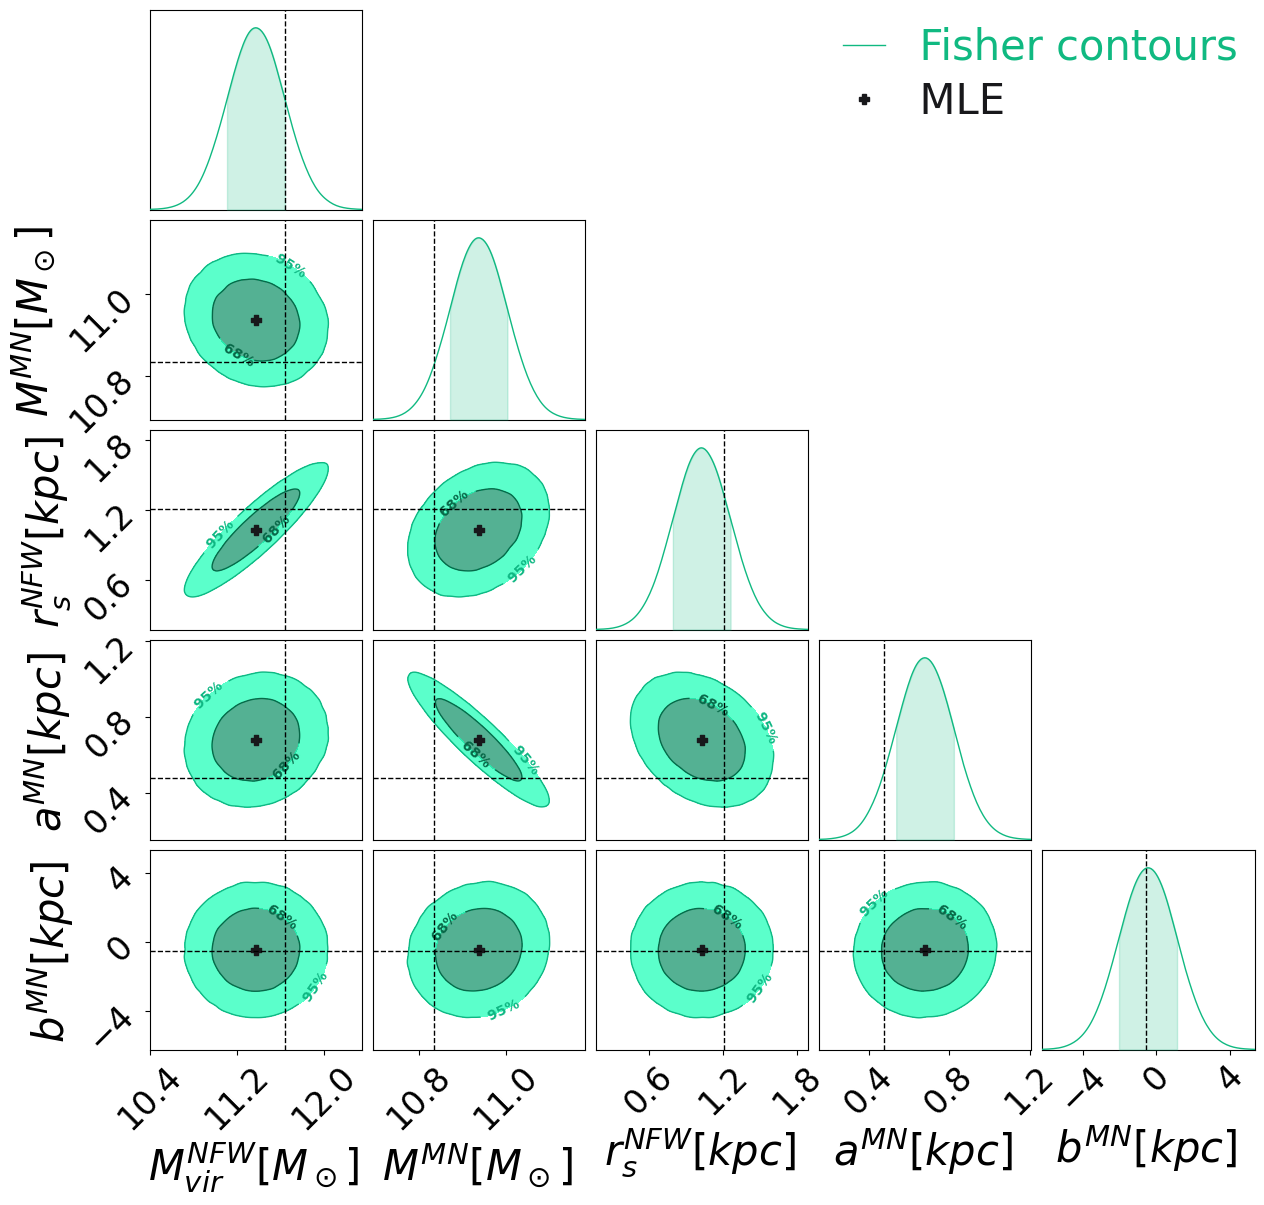

In [9]:
from chainconsumer import Chain, ChainConsumer, Truth, PlotConfig

colors = ['red', 'blue', 'green', 'purple']
c = ChainConsumer()
chain = Chain.from_covariance(mean=values[MLE_index], 
                                covariance=covariance, 
                                columns=["$M_{vir}^{NFW} [M_\odot]$", "$M^{MN} [M_\odot]$", "$r_s^{NFW} [kpc]$", "$a^{MN} [kpc]$", "$b^{MN} [kpc]$"], 
                                color="emerald",  
                                name=f'Fisher contours',
                                show_contour_labels=True,
                                shade_alpha=0.7
)

c.add_chain(chain)
c.add_marker(location = {"$M_{vir}^{NFW} [M_\odot]$": np.array(values[MLE_index][0]), "$M^{MN} [M_\odot]$": np.array(values[MLE_index][1]),
                            "$r_s^{NFW} [kpc]$": np.array(values[MLE_index][2]), "$a^{MN} [kpc]$": np.array(values[MLE_index][3]), "$b^{MN} [kpc]$": np.array(values[MLE_index][4]),
                            }, color="black", name='MLE', marker_style='P', marker_size=50)

c.add_truth(Truth(location = {"$M_{vir}^{NFW} [M_\odot]$": jnp.log10(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)), 
                            "$M^{MN} [M_\odot]$": jnp.log10(params.MN_params.M * code_units.code_mass.to(u.Msun)),
                            "$r_s^{NFW} [kpc]$": jnp.log10(params.NFW_params.r_s * code_units.code_length.to(u.kpc)),
                            "$a^{MN} [kpc]$": jnp.log10(params.MN_params.a * code_units.code_length.to(u.kpc)),
                            "$b^{MN} [kpc]$": jnp.log10(params.MN_params.b * code_units.code_length.to(u.kpc)),
                            }, 
                            color='black', name="True value"))


c.set_plot_config(
PlotConfig(
    max_ticks=3,
    label_font_size=30,
    tick_font_size=24,
    summary_font_size=20,

))
fig = c.plotter.plot()
fig.savefig("Fisher_contour_least_square_AllParameters_final.png", 
            dpi=300, bbox_inches='tight')